SHAPES
Train : (1017209, 9)
Test  : (41088, 8)
Store : (1115, 10)

TRAIN - First 5 rows
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  

TRAIN - Missing Values
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

TRAIN - Describe
              Store     DayOfWeek                           Date  \
count  1.017209e+06  1.017209e+06  

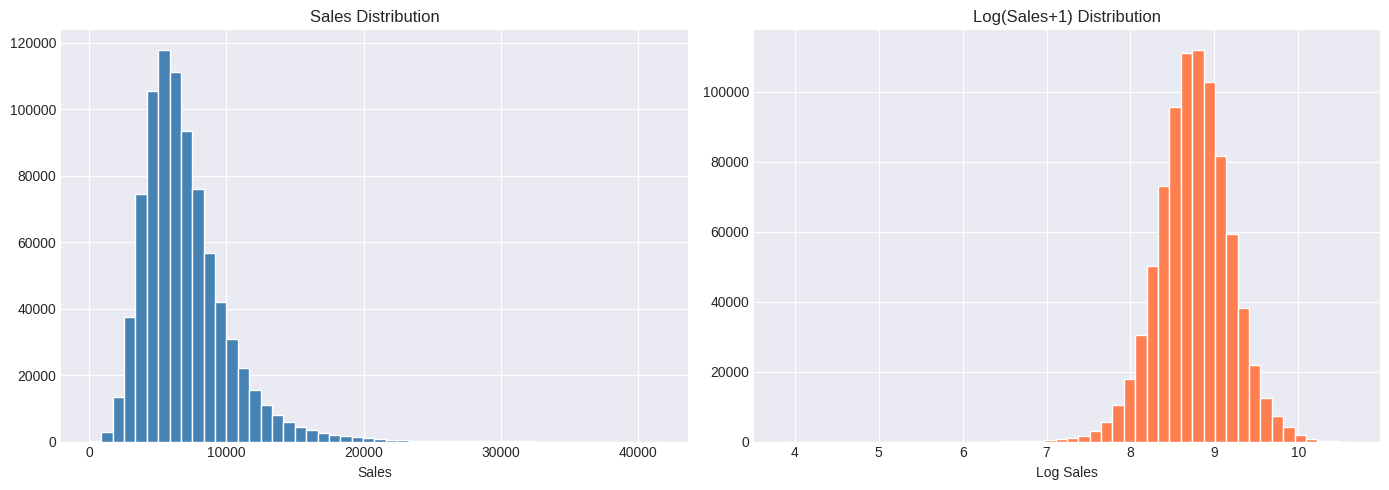

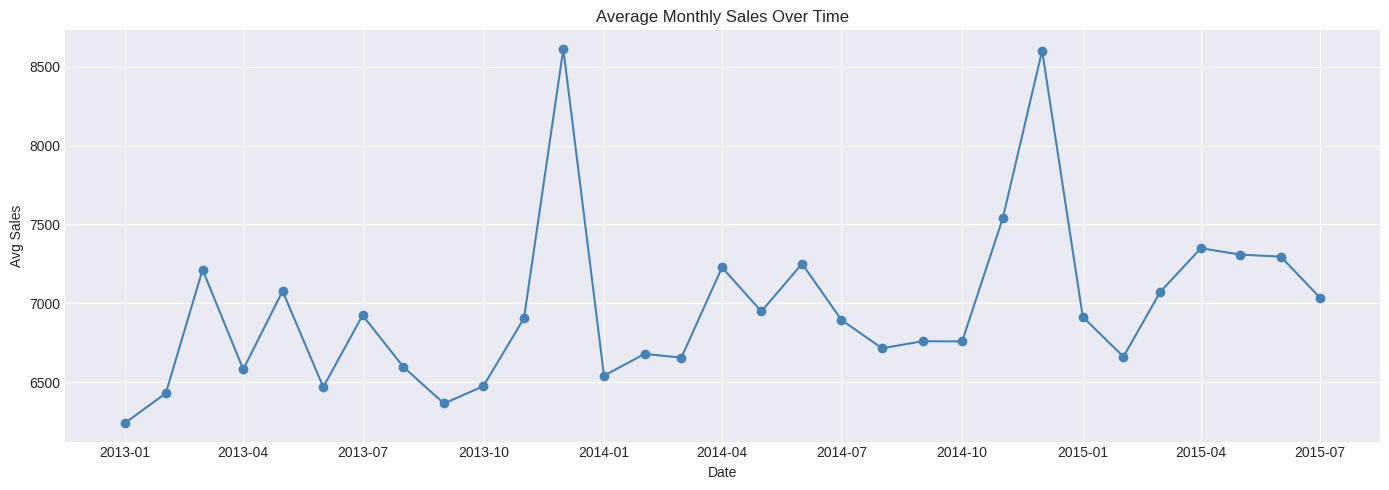

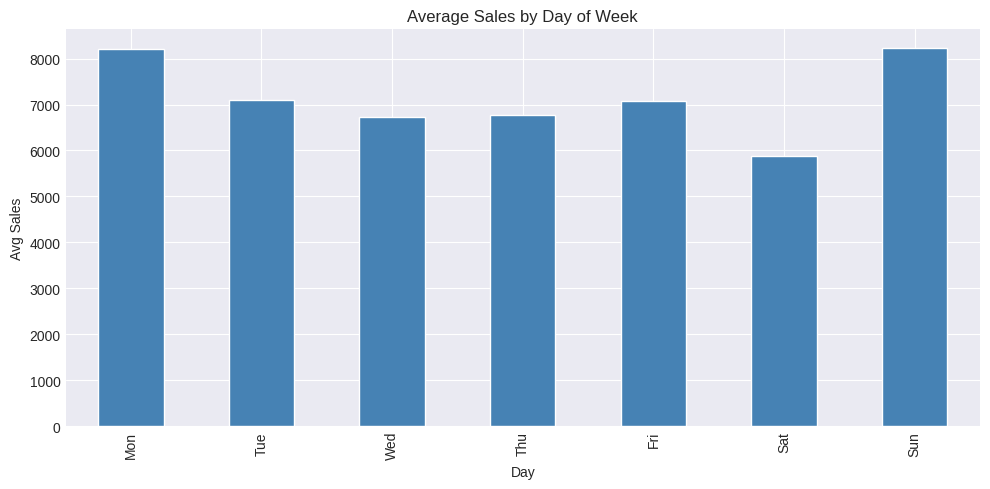

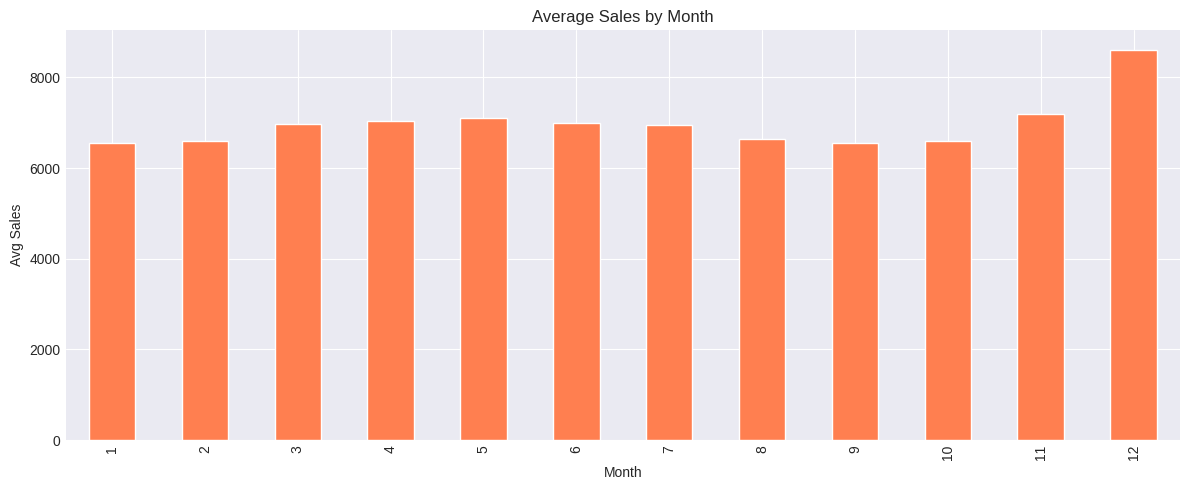

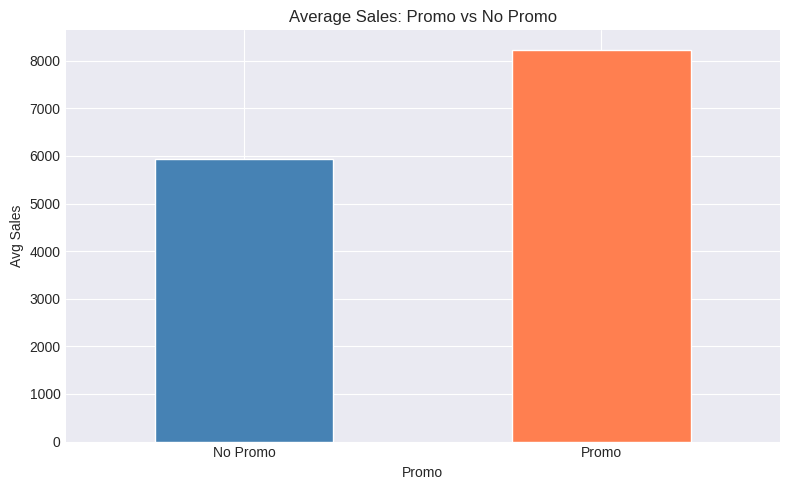

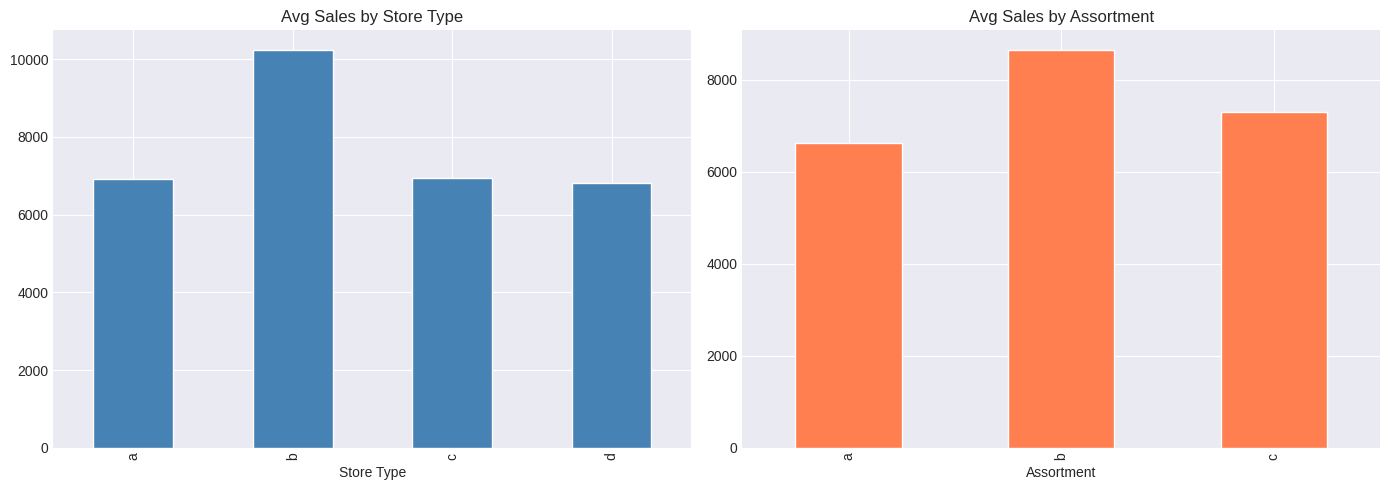

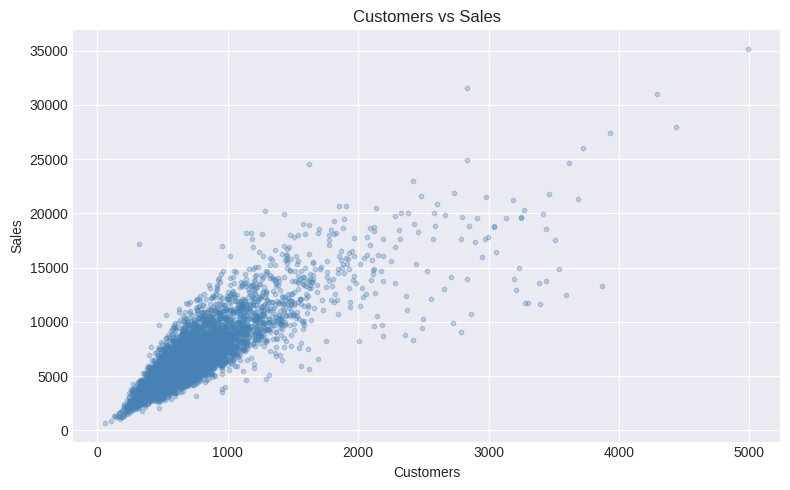

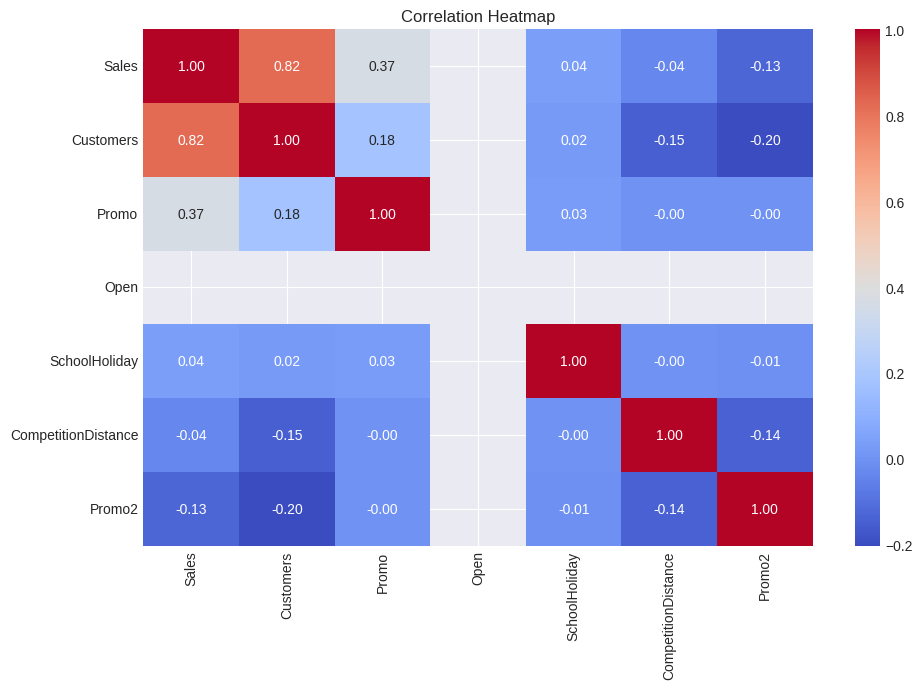

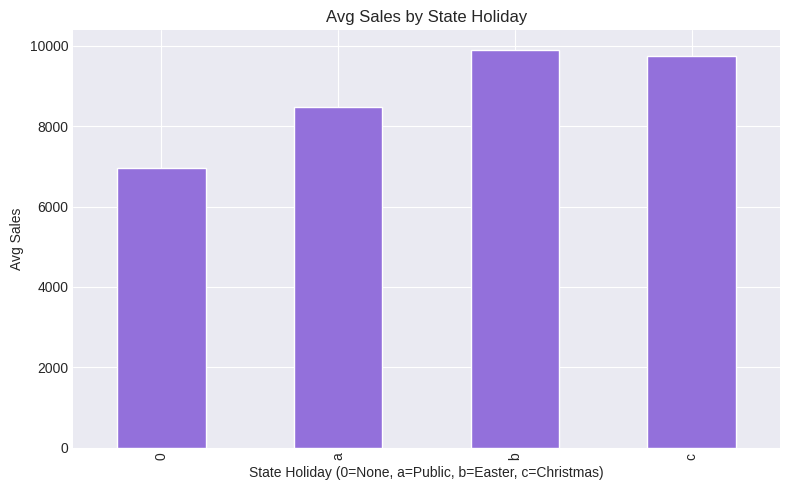

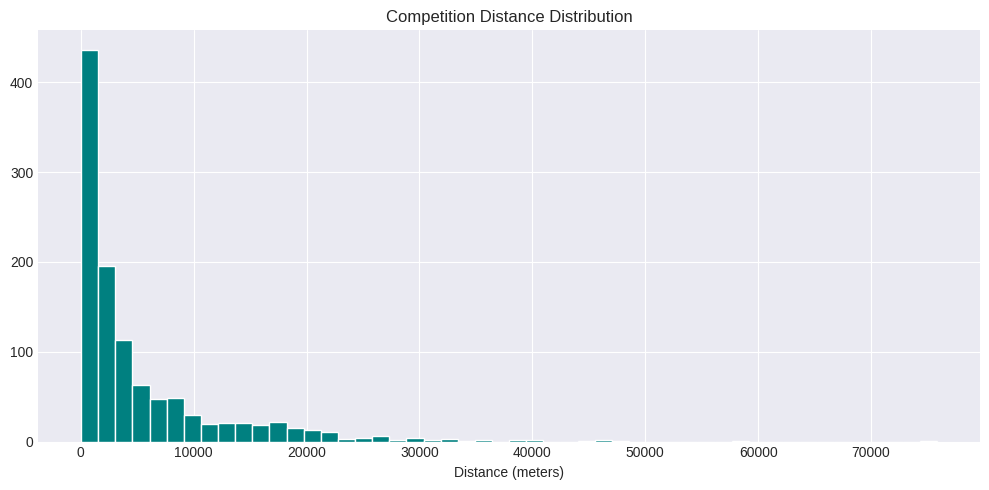


KEY INSIGHTS SUMMARY
Date Range          : 2013-01-01 --> 2015-07-31
Unique Stores       : 1115
Avg Daily Sales     : 6,956
Median Daily Sales  : 6,369
Max Daily Sales     : 41,551
Avg Customers/Day   : 763

Promo Lift          : 138.77%

Sales by Store Type:
StoreType
a     6926.0
b    10233.0
c     6933.0
d     6822.0
Name: Sales, dtype: float64

Sales by Assortment:
Assortment
a    6622.0
b    8643.0
c    7301.0
Name: Sales, dtype: float64

Missing Values in Merged df:
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

EDA Complete!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ─────────────────────────────────────────
# 1. LOAD DATA
# ─────────────────────────────────────────
DATA_PATH = '/kaggle/input/rossmann-store-sales/'

train = pd.read_csv(DATA_PATH + 'train.csv', parse_dates=['Date'], low_memory=False)
test  = pd.read_csv(DATA_PATH + 'test.csv',  parse_dates=['Date'], low_memory=False)
store = pd.read_csv(DATA_PATH + 'store.csv', low_memory=False)

print("=" * 60)
print("SHAPES")
print("=" * 60)
print(f"Train : {train.shape}")
print(f"Test  : {test.shape}")
print(f"Store : {store.shape}")

# ─────────────────────────────────────────
# 2. BASIC INFO
# ─────────────────────────────────────────
for name, df in [('TRAIN', train), ('TEST', test), ('STORE', store)]:
    print(f"\n{'='*60}")
    print(f"{name} - First 5 rows")
    print("="*60)
    print(df.head())
    print(f"\n{name} - Missing Values")
    print(df.isnull().sum())
    print(f"\n{name} - Describe")
    print(df.describe())

# ─────────────────────────────────────────
# 3. MERGE TRAIN + STORE
# ─────────────────────────────────────────
df = train.merge(store, on='Store', how='left')
print(f"\nMerged shape: {df.shape}")

# Filter only open stores with sales > 0
df = df[(df['Open'] == 1) & (df['Sales'] > 0)]
print(f"After filtering open & sales>0: {df.shape}")

# ─────────────────────────────────────────
# 4. DATE FEATURES
# ─────────────────────────────────────────
df['Year']       = df['Date'].dt.year
df['Month']      = df['Date'].dt.month
df['Day']        = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['DayOfWeek']  = df['Date'].dt.dayofweek

# ─────────────────────────────────────────
# 5. PLOTS
# ─────────────────────────────────────────
plt.style.use('seaborn-v0_8-darkgrid')
fig_size = (14, 5)

# --- 5.1 Sales Distribution ---
fig, axes = plt.subplots(1, 2, figsize=fig_size)
df['Sales'].hist(bins=50, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Sales Distribution')
axes[0].set_xlabel('Sales')
np.log1p(df['Sales']).hist(bins=50, ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('Log(Sales+1) Distribution')
axes[1].set_xlabel('Log Sales')
plt.tight_layout()
plt.savefig('sales_distribution.png', dpi=150)
plt.show()

# --- 5.2 Sales over Time ---
monthly = df.groupby(['Year', 'Month'])['Sales'].mean().reset_index()
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(Day=1))
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(monthly['Date'], monthly['Sales'], marker='o', color='steelblue')
ax.set_title('Average Monthly Sales Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Avg Sales')
plt.tight_layout()
plt.savefig('sales_over_time.png', dpi=150)
plt.show()

# --- 5.3 Sales by Day of Week ---
fig, ax = plt.subplots(figsize=(10, 5))
dow = df.groupby('DayOfWeek')['Sales'].mean()
dow.index = dow.index.map(lambda x: ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][x])
dow.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
ax.set_title('Average Sales by Day of Week')
ax.set_xlabel('Day')
ax.set_ylabel('Avg Sales')
plt.tight_layout()
plt.savefig('sales_by_dow.png', dpi=150)
plt.show()

# --- 5.4 Sales by Month ---
fig, ax = plt.subplots(figsize=(12, 5))
df.groupby('Month')['Sales'].mean().plot(kind='bar', ax=ax, color='coral', edgecolor='white')
ax.set_title('Average Sales by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Avg Sales')
plt.tight_layout()
plt.savefig('sales_by_month.png', dpi=150)
plt.show()

# --- 5.5 Promo Effect ---
fig, ax = plt.subplots(figsize=(8, 5))
df.groupby('Promo')['Sales'].mean().plot(kind='bar', ax=ax, color=['steelblue','coral'], edgecolor='white')
ax.set_title('Average Sales: Promo vs No Promo')
ax.set_xticklabels(['No Promo', 'Promo'], rotation=0)
ax.set_ylabel('Avg Sales')
plt.tight_layout()
plt.savefig('promo_effect.png', dpi=150)
plt.show()

# --- 5.6 Store Type & Assortment ---
fig, axes = plt.subplots(1, 2, figsize=fig_size)
df.groupby('StoreType')['Sales'].mean().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Avg Sales by Store Type')
axes[0].set_xlabel('Store Type')
df.groupby('Assortment')['Sales'].mean().plot(kind='bar', ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('Avg Sales by Assortment')
axes[1].set_xlabel('Assortment')
plt.tight_layout()
plt.savefig('store_type_assortment.png', dpi=150)
plt.show()

# --- 5.7 Customers vs Sales Scatter ---
fig, ax = plt.subplots(figsize=(8, 5))
sample = df.sample(5000, random_state=42)
ax.scatter(sample['Customers'], sample['Sales'], alpha=0.3, color='steelblue', s=10)
ax.set_title('Customers vs Sales')
ax.set_xlabel('Customers')
ax.set_ylabel('Sales')
plt.tight_layout()
plt.savefig('customers_vs_sales.png', dpi=150)
plt.show()

# --- 5.8 Correlation Heatmap ---
num_cols = ['Sales', 'Customers', 'Promo', 'Open', 'SchoolHoliday', 'CompetitionDistance', 'Promo2']
df_corr = df[num_cols].copy()
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df_corr.corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150)
plt.show()

# --- 5.9 Sales by StateHoliday ---
fig, ax = plt.subplots(figsize=(8, 5))
df.groupby('StateHoliday')['Sales'].mean().plot(kind='bar', ax=ax, color='mediumpurple', edgecolor='white')
ax.set_title('Avg Sales by State Holiday')
ax.set_xlabel('State Holiday (0=None, a=Public, b=Easter, c=Christmas)')
ax.set_ylabel('Avg Sales')
plt.tight_layout()
plt.savefig('sales_by_holiday.png', dpi=150)
plt.show()

# --- 5.10 Competition Distance Distribution ---
fig, ax = plt.subplots(figsize=(10, 5))
store['CompetitionDistance'].dropna().hist(bins=50, ax=ax, color='teal', edgecolor='white')
ax.set_title('Competition Distance Distribution')
ax.set_xlabel('Distance (meters)')
plt.tight_layout()
plt.savefig('competition_distance.png', dpi=150)
plt.show()

# ─────────────────────────────────────────
# 6. KEY INSIGHTS SUMMARY
# ─────────────────────────────────────────
print("\n" + "="*60)
print("KEY INSIGHTS SUMMARY")
print("="*60)
print(f"Date Range          : {df['Date'].min().date()} --> {df['Date'].max().date()}")
print(f"Unique Stores       : {df['Store'].nunique()}")
print(f"Avg Daily Sales     : {df['Sales'].mean():,.0f}")
print(f"Median Daily Sales  : {df['Sales'].median():,.0f}")
print(f"Max Daily Sales     : {df['Sales'].max():,.0f}")
print(f"Avg Customers/Day   : {df['Customers'].mean():,.0f}")
print(f"\nPromo Lift          : {df[df['Promo']==1]['Sales'].mean() / df[df['Promo']==0]['Sales'].mean():.2%}")
print(f"\nSales by Store Type:\n{df.groupby('StoreType')['Sales'].mean().round(0)}")
print(f"\nSales by Assortment:\n{df.groupby('Assortment')['Sales'].mean().round(0)}")
print(f"\nMissing Values in Merged df:\n{df.isnull().sum()[df.isnull().sum()>0]}")
print("\nEDA Complete!")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
DATA_PATH = '/kaggle/input/rossmann-store-sales/'

train = pd.read_csv(DATA_PATH + 'train.csv', parse_dates=['Date'], low_memory=False)
test  = pd.read_csv(DATA_PATH + 'test.csv',  parse_dates=['Date'], low_memory=False)
store = pd.read_csv(DATA_PATH + 'store.csv', low_memory=False)

print(f"Train : {train.shape}")
print(f"Test  : {test.shape}")
print(f"Store : {store.shape}")

Train : (1017209, 9)
Test  : (41088, 8)
Store : (1115, 10)


In [4]:
train = train.merge(store, on='Store', how='left')
test  = test.merge(store,  on='Store', how='left')

In [5]:
train = train[(train['Open'] == 1) & (train['Sales'] > 0)].copy()

In [6]:
test['Open'] = test['Open'].fillna(1)

In [7]:

train['StateHoliday'] = train['StateHoliday'].replace({'0': 0})
test['StateHoliday']  = test['StateHoliday'].replace({'0': 0})
comp_median = store['CompetitionDistance'].median()
train['CompetitionDistance'] = train['CompetitionDistance'].fillna(comp_median)
test['CompetitionDistance']  = test['CompetitionDistance'].fillna(comp_median)
print(f"Train after filter : {train.shape}")
print(f"Test shape         : {test.shape}")
print(" Preprocessing done!")


Train after filter : (844338, 18)
Test shape         : (41088, 17)
 Preprocessing done!


In [8]:
def add_date_features(df):
    df = df.copy()
    df['Year']        = df['Date'].dt.year
    df['Month']       = df['Date'].dt.month
    df['Day']         = df['Date'].dt.day
    df['WeekOfYear']  = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek']   = df['Date'].dt.dayofweek
    df['IsWeekend']   = (df['DayOfWeek'] >= 5).astype(int)
    df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
    df['IsMonthEnd']   = df['Date'].dt.is_month_end.astype(int)
    df['Quarter']     = df['Date'].dt.quarter
    return df

def encode_categoricals(df):
    df = df.copy()
    # StoreType: a=0, b=1, c=2, d=3
    df['StoreType']  = df['StoreType'].map({'a':0,'b':1,'c':2,'d':3})
    # Assortment: a=0, b=1, c=2
    df['Assortment'] = df['Assortment'].map({'a':0,'b':1,'c':2})
    # StateHoliday: 0=0, a=1, b=2, c=3
    df['StateHoliday'] = df['StateHoliday'].map({0:0,'0':0,'a':1,'b':2,'c':3}).fillna(0)
    return df

def add_competition_features(df):
    df = df.copy()
    df['CompetitionOpen'] = (
        12 * (df['Year'] - df['CompetitionOpenSinceYear'].fillna(df['Year'])) +
        (df['Month'] - df['CompetitionOpenSinceMonth'].fillna(df['Month']))
    ).clip(lower=0)
    df['Promo2Open'] = (
        12 * (df['Year'] - df['Promo2SinceYear'].fillna(df['Year'])) +
        (df['WeekOfYear'] - df['Promo2SinceWeek'].fillna(df['WeekOfYear'])) / 4.0
    ).clip(lower=0)
    return df

# Apply feature engineering
train = add_date_features(train)
test  = add_date_features(test)

train = encode_categoricals(train)
test  = encode_categoricals(test)

train = add_competition_features(train)
test  = add_competition_features(test)

print("Date features added ✅")
print("Categorical encoding done ✅")
print("Competition features added ✅")
print(f"\nTrain columns ({len(train.columns)}):\n{list(train.columns)}")


Date features added ✅
Categorical encoding done ✅
Competition features added ✅

Train columns (28):
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day', 'WeekOfYear', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'Quarter', 'CompetitionOpen', 'Promo2Open']


In [9]:
 #Sort for lag computation
train = train.sort_values(['Store', 'Date']).reset_index(drop=True)

# Store-level historical average sales (powerful feature!)
store_avg = train.groupby('Store')['Sales'].mean().rename('StoreAvgSales')
store_med = train.groupby('Store')['Sales'].median().rename('StoreMedianSales')
store_std = train.groupby('Store')['Sales'].std().rename('StoreStdSales')

store_promo_avg    = train[train['Promo']==1].groupby('Store')['Sales'].mean().rename('StorePromoAvgSales')
store_noPromo_avg  = train[train['Promo']==0].groupby('Store')['Sales'].mean().rename('StoreNoPromoAvgSales')

# Merge back
for feat in [store_avg, store_med, store_std, store_promo_avg, store_noPromo_avg]:
    train = train.merge(feat, on='Store', how='left')
    test  = test.merge(feat,  on='Store', how='left')

# Day-of-week average per store
dow_avg = train.groupby(['Store','DayOfWeek'])['Sales'].mean().rename('StoreDowAvgSales').reset_index()
train = train.merge(dow_avg, on=['Store','DayOfWeek'], how='left')
test  = test.merge(dow_avg,  on=['Store','DayOfWeek'], how='left')

# Month average per store
month_avg = train.groupby(['Store','Month'])['Sales'].mean().rename('StoreMonthAvgSales').reset_index()
train = train.merge(month_avg, on=['Store','Month'], how='left')
test  = test.merge(month_avg,  on=['Store','Month'], how='left')

print("✅ Store-level lag/aggregate features added!")
print(f"Train shape: {train.shape}")
print(f"Test shape : {test.shape}")


✅ Store-level lag/aggregate features added!
Train shape: (844338, 35)
Test shape : (41088, 34)


In [10]:
FEATURES = [
    # Store info
    'Store', 'StoreType', 'Assortment',
    # Time
    'Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek',
    'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'Quarter',
    # Promo & Holiday
    'Promo', 'Promo2', 'StateHoliday', 'SchoolHoliday',
    # Competition
    'CompetitionDistance', 'CompetitionOpen',
    # Promo2 open duration
    'Promo2Open',
    # Store-level aggregates
    'StoreAvgSales', 'StoreMedianSales', 'StoreStdSales',
    'StorePromoAvgSales', 'StoreNoPromoAvgSales',
    'StoreDowAvgSales', 'StoreMonthAvgSales',
]

TARGET = 'Sales'

# Log-transform target (reduces RMSPE significantly)
train['LogSales'] = np.log1p(train[TARGET])

X = train[FEATURES]
y = train['LogSales']

print(f"Features used: {len(FEATURES)}")
print(FEATURES)

Features used: 26
['Store', 'StoreType', 'Assortment', 'Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'Quarter', 'Promo', 'Promo2', 'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpen', 'Promo2Open', 'StoreAvgSales', 'StoreMedianSales', 'StoreStdSales', 'StorePromoAvgSales', 'StoreNoPromoAvgSales', 'StoreDowAvgSales', 'StoreMonthAvgSales']


In [11]:
# Use last 6 weeks as validation (mimics the test set period)
cutoff_date = train['Date'].max() - pd.Timedelta(weeks=6)

train_idx = train['Date'] <= cutoff_date
val_idx   = train['Date'] >  cutoff_date

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]

print(f"Train set : {X_train.shape}  ({train['Date'][train_idx].min().date()} → {train['Date'][train_idx].max().date()})")
print(f"Val set   : {X_val.shape}    ({train['Date'][val_idx].min().date()} → {train['Date'][val_idx].max().date()})")



Train set : (804056, 26)  (2013-01-01 → 2015-06-19)
Val set   : (40282, 26)    (2015-06-20 → 2015-07-31)


In [12]:
# ─────────────────────────────────────────────────────────────
params = {
    'objective'       : 'regression',
    'metric'          : 'rmse',
    'learning_rate'   : 0.05,
    'num_leaves'      : 127,
    'max_depth'       : -1,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq'    : 5,
    'reg_alpha'       : 0.1,
    'reg_lambda'      : 0.1,
    'n_jobs'          : -1,
    'verbose'         : -1,
    'random_state'    : 42,
}

dtrain = lgb.Dataset(X_train, label=y_train)
dval   = lgb.Dataset(X_val,   label=y_val, reference=dtrain)

print("Training LightGBM model...")
model = lgb.train(
    params,
    dtrain,
    num_boost_round    = 2000,
    valid_sets         = [dtrain, dval],
    valid_names        = ['train', 'val'],
    callbacks          = [
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\n✅ Training complete!")
print(f"Best iteration: {model.best_iteration}")

Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.116542	val's rmse: 0.135228
[200]	train's rmse: 0.104471	val's rmse: 0.127582
[300]	train's rmse: 0.0993296	val's rmse: 0.125245
[400]	train's rmse: 0.0960987	val's rmse: 0.123349
[500]	train's rmse: 0.093797	val's rmse: 0.122642
[600]	train's rmse: 0.0919989	val's rmse: 0.121793
[700]	train's rmse: 0.090525	val's rmse: 0.121468
[800]	train's rmse: 0.0892181	val's rmse: 0.120978
[900]	train's rmse: 0.0880839	val's rmse: 0.120702
[1000]	train's rmse: 0.0870663	val's rmse: 0.120366
[1100]	train's rmse: 0.086158	val's rmse: 0.120171
[1200]	train's rmse: 0.0852922	val's rmse: 0.119976
[1300]	train's rmse: 0.084472	val's rmse: 0.119733
[1400]	train's rmse: 0.0837116	val's rmse: 0.11946
[1500]	train's rmse: 0.083022	val's rmse: 0.11932
Early stopping, best iteration is:
[1480]	train's rmse: 0.0831649	val's rmse: 0.119316

✅ Training complete!
Best iteration: 1480


In [13]:
def rmspe(y_true, y_pred):
    """Root Mean Square Percentage Error - official Kaggle metric"""
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2))

# Predict on validation (inverse log transform)
val_preds_log = model.predict(X_val, num_iteration=model.best_iteration)
val_preds     = np.expm1(val_preds_log)
val_actuals   = np.expm1(y_val)

score = rmspe(val_actuals.values, val_preds)
print(f"\n{'='*50}")
print(f"  Validation RMSPE : {score:.4f}")
print(f"  (Lower is better. Kaggle top scores ~0.10-0.11)")
print(f"{'='*50}")



  Validation RMSPE : 0.1308
  (Lower is better. Kaggle top scores ~0.10-0.11)


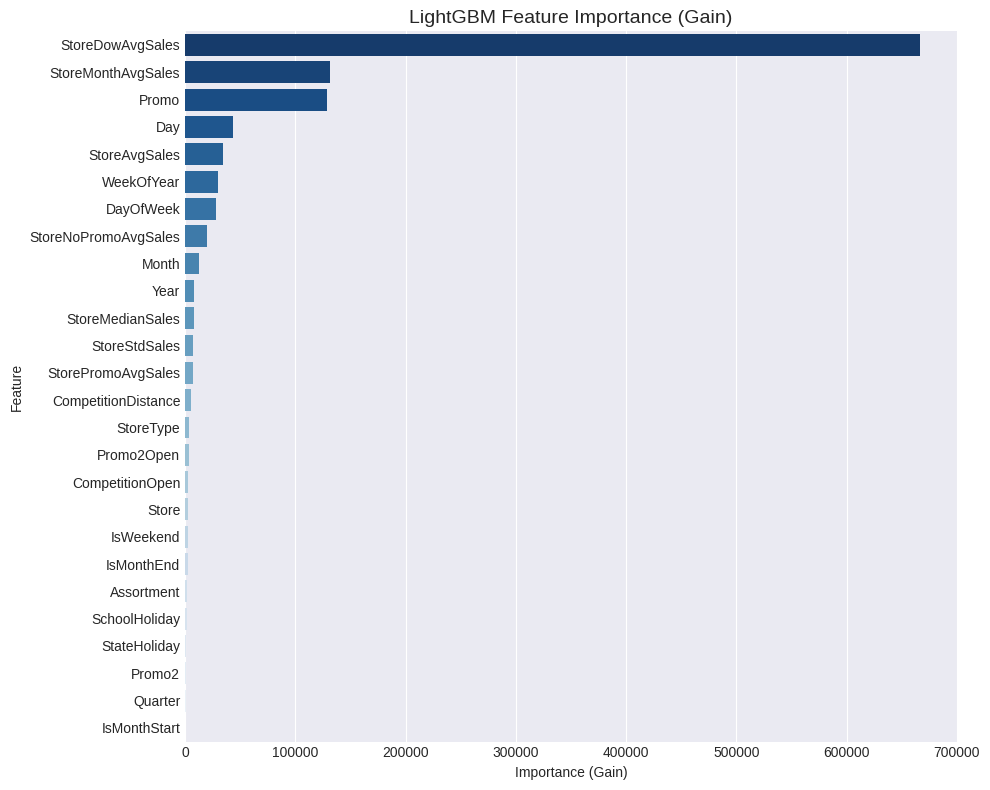


Top 10 Features:
             Feature    Importance
    StoreDowAvgSales 666904.076746
  StoreMonthAvgSales 131651.563870
               Promo 128779.830702
                 Day  43433.406403
       StoreAvgSales  34026.940430
          WeekOfYear  29779.068199
           DayOfWeek  27643.790220
StoreNoPromoAvgSales  19364.956021
               Month  12611.411143
                Year   8463.788255


In [14]:
feat_imp = pd.DataFrame({
    'Feature'   : FEATURES,
    'Importance': model.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='Blues_r', ax=ax)
ax.set_title('LightGBM Feature Importance (Gain)', fontsize=14)
ax.set_xlabel('Importance (Gain)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

print("\nTop 10 Features:")
print(feat_imp.head(10).to_string(index=False))


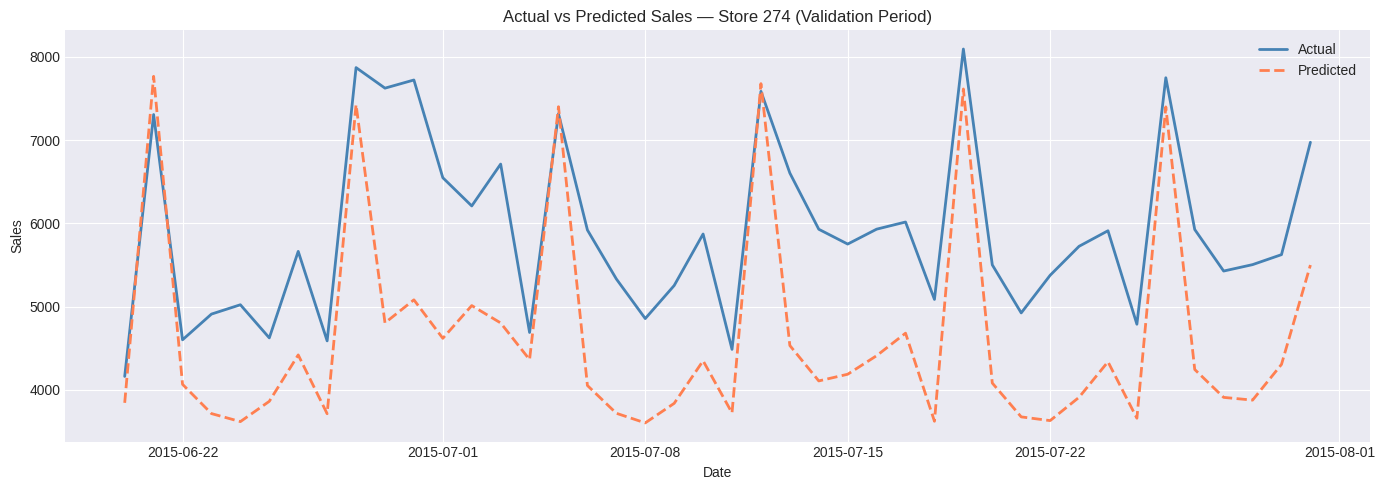

In [15]:
val_df = train[val_idx].copy()
val_df['PredictedSales'] = val_preds

# Pick one store to visualize
store_id = val_df['Store'].value_counts().index[0]
store_val = val_df[val_df['Store'] == store_id].sort_values('Date')

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(store_val['Date'], store_val['Sales'],          label='Actual',    color='steelblue', linewidth=2)
ax.plot(store_val['Date'], store_val['PredictedSales'], label='Predicted', color='coral',     linewidth=2, linestyle='--')
ax.set_title(f'Actual vs Predicted Sales — Store {store_id} (Validation Period)')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.tight_layout()
plt.savefig('predictions_vs_actuals.png', dpi=150)
plt.show()

In [16]:
X_test = test[FEATURES]

test_preds_log = model.predict(X_test, num_iteration=model.best_iteration)
test_preds     = np.expm1(test_preds_log)

# Closed stores should have 0 sales
test_preds[test['Open'] == 0] = 0

# Build submission
submission = pd.DataFrame({
    'Id'   : test['Id'],
    'Sales': test_preds
})

submission.to_csv('submission.csv', index=False)

print(f"✅ Submission saved! Shape: {submission.shape}")
print(submission.head(10))
print(f"\nSales stats:")
print(submission['Sales'].describe().round(2))

✅ Submission saved! Shape: (41088, 2)
   Id        Sales
0   1  4156.451920
1   2  7425.316647
2   3  8899.938469
3   4  6899.657273
4   5  6911.839199
5   6  5431.218185
6   7  7588.147718
7   8  7706.386765
8   9  4801.247863
9  10  5546.001886

Sales stats:
count    41088.00
mean      5919.88
std       3537.81
min          0.00
25%       4246.12
50%       5936.87
75%       7820.88
max      29359.13
Name: Sales, dtype: float64


✅ Libraries loaded!
Train: (844338, 18) | Test: (41088, 17)
✅ Preprocessing done!
✅ Date & competition features added!
✅ Store-level aggregate features added!
Computing rolling lag features (this may take ~1 min)...
✅ Rolling lag features added!
✅ Interaction features added!
Total features: 38
Train: (804056, 38) | Val: (40282, 38)
Training improved LightGBM model...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.10786	val's rmse: 0.119641
[400]	train's rmse: 0.0952426	val's rmse: 0.112719
[600]	train's rmse: 0.0892607	val's rmse: 0.109608
[800]	train's rmse: 0.0861205	val's rmse: 0.108408
[1000]	train's rmse: 0.0840563	val's rmse: 0.107731
[1200]	train's rmse: 0.0824034	val's rmse: 0.107298
[1400]	train's rmse: 0.0810479	val's rmse: 0.106935
[1600]	train's rmse: 0.0798597	val's rmse: 0.106727
[1800]	train's rmse: 0.0787646	val's rmse: 0.106599
[2000]	train's rmse: 0.0778085	val's rmse: 0.10644
[2200]	train's rmse: 0.0768894	val's rmse: 0.106359
[24

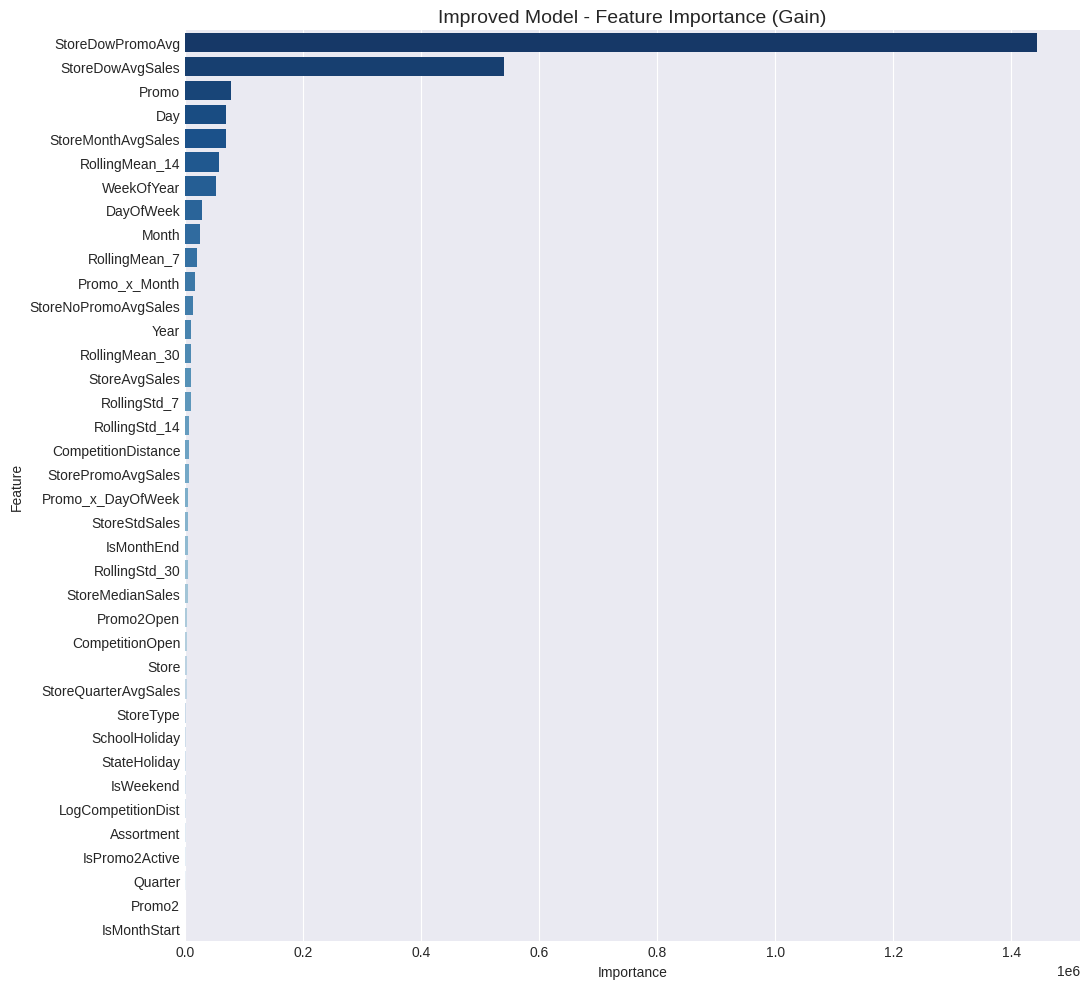


Top 10 Features:
           Feature   Importance
  StoreDowPromoAvg 1.444200e+06
  StoreDowAvgSales 5.398569e+05
             Promo 7.689243e+04
               Day 6.947922e+04
StoreMonthAvgSales 6.873993e+04
    RollingMean_14 5.677576e+04
        WeekOfYear 5.277867e+04
         DayOfWeek 2.798964e+04
             Month 2.467068e+04
     RollingMean_7 2.041054e+04
✅ submission_v2.csv saved! Shape: (41088, 2)
   Id        Sales
0   1  4472.587936
1   2  7226.279127
2   3  9491.561377
3   4  7140.039920
4   5  6784.853100


In [17]:

# ─────────────────────────────────────────────────────────────
# CELL 1: IMPORTS
# ─────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded!")


# ─────────────────────────────────────────────────────────────
# CELL 2: LOAD DATA
# ─────────────────────────────────────────────────────────────
DATA_PATH = '/kaggle/input/rossmann-store-sales/'

train = pd.read_csv(DATA_PATH + 'train.csv', parse_dates=['Date'], low_memory=False)
test  = pd.read_csv(DATA_PATH + 'test.csv',  parse_dates=['Date'], low_memory=False)
store = pd.read_csv(DATA_PATH + 'store.csv', low_memory=False)

# Merge store info
train = train.merge(store, on='Store', how='left')
test  = test.merge(store,  on='Store', how='left')

# Filter train
train = train[(train['Open'] == 1) & (train['Sales'] > 0)].copy()
test['Open'] = test['Open'].fillna(1)

print(f"Train: {train.shape} | Test: {test.shape}")


# ─────────────────────────────────────────────────────────────
# CELL 3: PREPROCESSING
# ─────────────────────────────────────────────────────────────
def preprocess(df):
    df = df.copy()
    # Fix StateHoliday
    df['StateHoliday'] = df['StateHoliday'].replace({'0': 0})
    df['StateHoliday'] = df['StateHoliday'].map({0:0,'0':0,'a':1,'b':2,'c':3}).fillna(0)
    # Encode categoricals
    df['StoreType']  = df['StoreType'].map({'a':0,'b':1,'c':2,'d':3})
    df['Assortment'] = df['Assortment'].map({'a':0,'b':1,'c':2})
    # Fill missing CompetitionDistance
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())
    return df

train = preprocess(train)
test  = preprocess(test)
print("✅ Preprocessing done!")


# ─────────────────────────────────────────────────────────────
# CELL 4: DATE + COMPETITION FEATURES
# ─────────────────────────────────────────────────────────────
def add_date_features(df):
    df = df.copy()
    df['Year']         = df['Date'].dt.year
    df['Month']        = df['Date'].dt.month
    df['Day']          = df['Date'].dt.day
    df['WeekOfYear']   = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek']    = df['Date'].dt.dayofweek
    df['IsWeekend']    = (df['DayOfWeek'] >= 5).astype(int)
    df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
    df['IsMonthEnd']   = df['Date'].dt.is_month_end.astype(int)
    df['Quarter']      = df['Date'].dt.quarter

    # Competition open duration in months
    df['CompetitionOpen'] = (
        12 * (df['Year'] - df['CompetitionOpenSinceYear'].fillna(df['Year'])) +
        (df['Month'] - df['CompetitionOpenSinceMonth'].fillna(df['Month']))
    ).clip(lower=0)

    # Promo2 open duration
    df['Promo2Open'] = (
        12 * (df['Year'] - df['Promo2SinceYear'].fillna(df['Year'])) +
        (df['WeekOfYear'] - df['Promo2SinceWeek'].fillna(df['WeekOfYear'])) / 4.0
    ).clip(lower=0)

    # ✨ NEW: Is Promo2 active this month?
    promo2_months_map = {
        'Jan,Apr,Jul,Oct' : [1,4,7,10],
        'Feb,May,Aug,Nov' : [2,5,8,11],
        'Mar,Jun,Sept,Dec': [3,6,9,12],
    }
    def is_promo2_active(row):
        if row['Promo2'] == 0 or pd.isna(row.get('PromoInterval')):
            return 0
        months = promo2_months_map.get(row['PromoInterval'], [])
        return 1 if row['Month'] in months else 0

    if 'PromoInterval' in df.columns:
        df['IsPromo2Active'] = df.apply(is_promo2_active, axis=1)
    else:
        df['IsPromo2Active'] = 0

    return df

train = add_date_features(train)
test  = add_date_features(test)
print("✅ Date & competition features added!")


# ─────────────────────────────────────────────────────────────
# CELL 5: STORE-LEVEL AGGREGATE FEATURES
# ─────────────────────────────────────────────────────────────
train = train.sort_values(['Store', 'Date']).reset_index(drop=True)

# Overall store stats
for agg_name, agg_func in [('StoreAvgSales','mean'), ('StoreMedianSales','median'), ('StoreStdSales','std')]:
    feat = train.groupby('Store')['Sales'].agg(agg_func).rename(agg_name)
    train = train.merge(feat, on='Store', how='left')
    test  = test.merge(feat,  on='Store', how='left')

# Promo / No-promo store averages
promo_avg    = train[train['Promo']==1].groupby('Store')['Sales'].mean().rename('StorePromoAvgSales')
no_promo_avg = train[train['Promo']==0].groupby('Store')['Sales'].mean().rename('StoreNoPromoAvgSales')
for feat in [promo_avg, no_promo_avg]:
    train = train.merge(feat, on='Store', how='left')
    test  = test.merge(feat,  on='Store', how='left')

# Store × DayOfWeek average
dow_avg = train.groupby(['Store','DayOfWeek'])['Sales'].mean().rename('StoreDowAvgSales').reset_index()
train = train.merge(dow_avg, on=['Store','DayOfWeek'], how='left')
test  = test.merge(dow_avg,  on=['Store','DayOfWeek'], how='left')

# Store × Month average
month_avg = train.groupby(['Store','Month'])['Sales'].mean().rename('StoreMonthAvgSales').reset_index()
train = train.merge(month_avg, on=['Store','Month'], how='left')
test  = test.merge(month_avg,  on=['Store','Month'], how='left')

# ✨ NEW: Store × DayOfWeek × Promo average
dow_promo_avg = train.groupby(['Store','DayOfWeek','Promo'])['Sales'].mean().rename('StoreDowPromoAvg').reset_index()
train = train.merge(dow_promo_avg, on=['Store','DayOfWeek','Promo'], how='left')
test  = test.merge(dow_promo_avg,  on=['Store','DayOfWeek','Promo'], how='left')

# ✨ NEW: Store × Quarter average
quarter_avg = train.groupby(['Store','Quarter'])['Sales'].mean().rename('StoreQuarterAvgSales').reset_index()
train = train.merge(quarter_avg, on=['Store','Quarter'], how='left')
test  = test.merge(quarter_avg,  on=['Store','Quarter'], how='left')

print("✅ Store-level aggregate features added!")


# ─────────────────────────────────────────────────────────────
# CELL 6: ✨ NEW - ROLLING LAG FEATURES
# ─────────────────────────────────────────────────────────────
# These are the biggest improvement over the baseline model!
# We compute rolling averages per store from historical data only.

print("Computing rolling lag features (this may take ~1 min)...")

train = train.sort_values(['Store', 'Date']).reset_index(drop=True)

# For each store, compute rolling stats with a shift to avoid data leakage
for window in [7, 14, 30]:
    col_mean = f'RollingMean_{window}'
    col_std  = f'RollingStd_{window}'
    train[col_mean] = (
        train.groupby('Store')['Sales']
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
    )
    train[col_std] = (
        train.groupby('Store')['Sales']
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).std())
    )

# For test set, use the last known rolling values from train
last_rolling = train.groupby('Store').last().reset_index()[
    ['Store', 'RollingMean_7', 'RollingMean_14', 'RollingMean_30',
     'RollingStd_7', 'RollingStd_14', 'RollingStd_30']
]
test = test.merge(last_rolling, on='Store', how='left')

print("✅ Rolling lag features added!")


# ─────────────────────────────────────────────────────────────
# CELL 7: ✨ NEW - INTERACTION FEATURES
# ─────────────────────────────────────────────────────────────
for df in [train, test]:
    # Promo × DayOfWeek
    df['Promo_x_DayOfWeek']  = df['Promo'] * df['DayOfWeek']
    # Promo × Month
    df['Promo_x_Month']      = df['Promo'] * df['Month']
    # CompetitionDistance log (skewed feature)
    df['LogCompetitionDist'] = np.log1p(df['CompetitionDistance'])
    # Sales per customer proxy (store average)
    df['SalesPerCustomer']   = df['StoreAvgSales'] / (df['StoreAvgSales'] / 100).clip(lower=1)

print("✅ Interaction features added!")


# ─────────────────────────────────────────────────────────────
# CELL 8: DEFINE FEATURES & TARGET
# ─────────────────────────────────────────────────────────────
FEATURES = [
    # Store
    'Store', 'StoreType', 'Assortment',
    # Time
    'Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek',
    'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'Quarter',
    # Promo & Holiday
    'Promo', 'Promo2', 'IsPromo2Active', 'StateHoliday', 'SchoolHoliday',
    # Competition
    'CompetitionDistance', 'LogCompetitionDist', 'CompetitionOpen',
    'Promo2Open',
    # Store aggregates
    'StoreAvgSales', 'StoreMedianSales', 'StoreStdSales',
    'StorePromoAvgSales', 'StoreNoPromoAvgSales',
    'StoreDowAvgSales', 'StoreMonthAvgSales',
    'StoreDowPromoAvg', 'StoreQuarterAvgSales',
    # ✨ Rolling lags
    'RollingMean_7', 'RollingMean_14', 'RollingMean_30',
    'RollingStd_7',  'RollingStd_14',  'RollingStd_30',
    # ✨ Interactions
    'Promo_x_DayOfWeek', 'Promo_x_Month',
]

train['LogSales'] = np.log1p(train['Sales'])

X = train[FEATURES]
y = train['LogSales']

print(f"Total features: {len(FEATURES)}")


# ─────────────────────────────────────────────────────────────
# CELL 9: TRAIN / VALIDATION SPLIT
# ─────────────────────────────────────────────────────────────
cutoff_date = train['Date'].max() - pd.Timedelta(weeks=6)
train_idx = train['Date'] <= cutoff_date
val_idx   = train['Date'] >  cutoff_date

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]

print(f"Train: {X_train.shape} | Val: {X_val.shape}")


# ─────────────────────────────────────────────────────────────
# CELL 10: TRAIN IMPROVED LIGHTGBM
# ─────────────────────────────────────────────────────────────
# ✨ Better tuned hyperparameters
params = {
    'objective'        : 'regression',
    'metric'           : 'rmse',
    'learning_rate'    : 0.02,       # Slower learning = better generalization
    'num_leaves'       : 255,        # More leaves = more complex patterns
    'max_depth'        : -1,
    'min_child_samples': 20,
    'feature_fraction' : 0.7,
    'bagging_fraction' : 0.7,
    'bagging_freq'     : 5,
    'reg_alpha'        : 0.1,
    'reg_lambda'       : 0.2,
    'n_jobs'           : -1,
    'verbose'          : -1,
    'random_state'     : 42,
}

dtrain = lgb.Dataset(X_train, label=y_train)
dval   = lgb.Dataset(X_val,   label=y_val, reference=dtrain)

print("Training improved LightGBM model...")
model = lgb.train(
    params,
    dtrain,
    num_boost_round = 5000,        # More rounds with early stopping
    valid_sets      = [dtrain, dval],
    valid_names     = ['train', 'val'],
    callbacks       = [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=200)
    ]
)

print(f"\n✅ Training complete! Best iteration: {model.best_iteration}")


# ─────────────────────────────────────────────────────────────
# CELL 11: EVALUATE (RMSPE)
# ─────────────────────────────────────────────────────────────
def rmspe(y_true, y_pred):
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2))

val_preds   = np.expm1(model.predict(X_val, num_iteration=model.best_iteration))
val_actuals = np.expm1(y_val)
score = rmspe(val_actuals.values, val_preds)

print(f"\n{'='*50}")
print(f"  Previous RMSPE   : 0.1308")
print(f"  Improved RMSPE   : {score:.4f}")
print(f"  Improvement      : {0.1308 - score:.4f} ({'✅ Better' if score < 0.1308 else '❌ Worse'})")
print(f"  Kaggle Top Score : ~0.10-0.11")
print(f"{'='*50}")


# ─────────────────────────────────────────────────────────────
# CELL 12: FEATURE IMPORTANCE
# ─────────────────────────────────────────────────────────────
feat_imp = pd.DataFrame({
    'Feature'   : FEATURES,
    'Importance': model.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(11, 10))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='Blues_r', ax=ax)
ax.set_title('Improved Model - Feature Importance (Gain)', fontsize=14)
plt.tight_layout()
plt.savefig('feature_importance_v2.png', dpi=150)
plt.show()

print("\nTop 10 Features:")
print(feat_imp.head(10).to_string(index=False))


# ─────────────────────────────────────────────────────────────
# CELL 13: PREDICT & SUBMISSION
# ─────────────────────────────────────────────────────────────
X_test = test[FEATURES]
test_preds = np.expm1(model.predict(X_test, num_iteration=model.best_iteration))
test_preds[test['Open'] == 0] = 0

submission = pd.DataFrame({'Id': test['Id'], 'Sales': test_preds})
submission.to_csv('submission_v2.csv', index=False)

print(f"✅ submission_v2.csv saved! Shape: {submission.shape}")
print(submission.head())

Top 15 Worst Predicted Stores:
        RMSPE    AvgSales  Count
Store                           
292    1.3131   7328.3333     18
909    1.0225  15827.8636     22
876    0.5183  11256.1364     22
782    0.4925   5301.3056     36
534    0.2643   7641.7778     36
956    0.2255   3069.9722     36
636    0.2130   6597.3611     36
183    0.2095   6093.1290     31
1014   0.2094  10047.5833     36
710    0.2087   4667.7500     36
612    0.2082   6439.8333     36
516    0.2077   5814.0000     36
501    0.2059   4858.5278     36
695    0.1995   5507.9444     36
13     0.1913   5244.5833     36

Stores with RMSPE > 0.20 : 13 stores


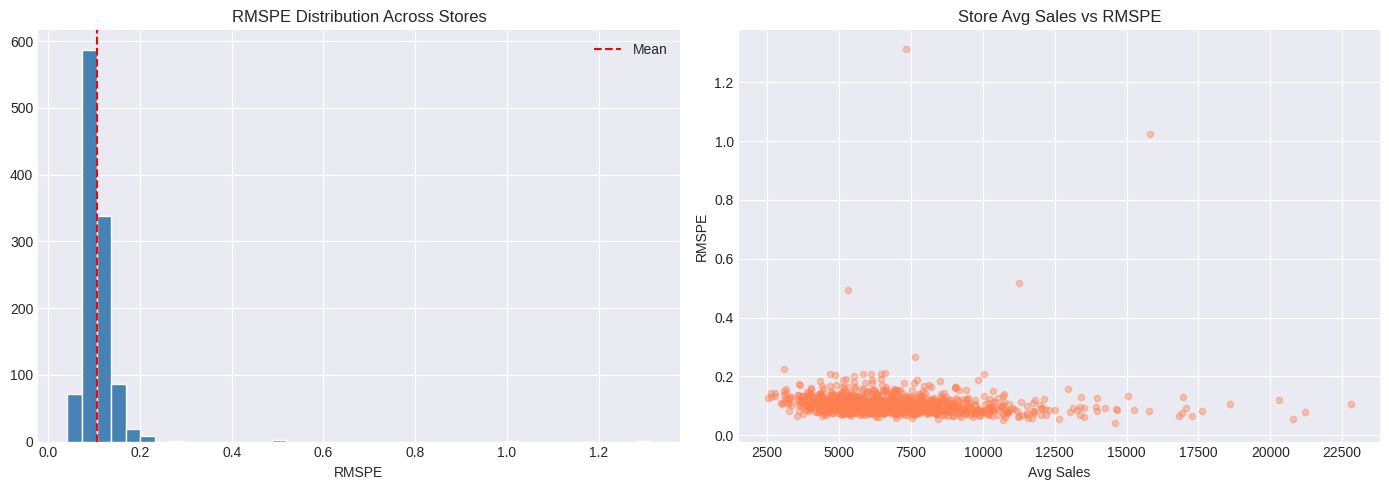

In [18]:
# ─────────────────────────────────────────
# DIAGNOSTIC: Find worst predicted stores
# ─────────────────────────────────────────
val_df = train[val_idx].copy()
val_df['PredictedSales'] = val_preds
val_df['RMSPE_contrib']  = ((val_df['Sales'] - val_df['PredictedSales']) / val_df['Sales']) ** 2

store_error = val_df.groupby('Store').agg(
    RMSPE    = ('RMSPE_contrib', lambda x: np.sqrt(x.mean())),
    AvgSales = ('Sales', 'mean'),
    Count    = ('Sales', 'count')
).sort_values('RMSPE', ascending=False)

print("Top 15 Worst Predicted Stores:")
print(store_error.head(15).round(4).to_string())

bad_stores = store_error[store_error['RMSPE'] > 0.2]
print(f"\nStores with RMSPE > 0.20 : {len(bad_stores)} stores")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
store_error['RMSPE'].hist(bins=40, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].axvline(store_error['RMSPE'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_title('RMSPE Distribution Across Stores')
axes[0].set_xlabel('RMSPE')
axes[0].legend()

axes[1].scatter(store_error['AvgSales'], store_error['RMSPE'], alpha=0.4, color='coral', s=20)
axes[1].set_title('Store Avg Sales vs RMSPE')
axes[1].set_xlabel('Avg Sales')
axes[1].set_ylabel('RMSPE')
plt.tight_layout()
plt.savefig('store_error_analysis.png', dpi=150)
plt.show()

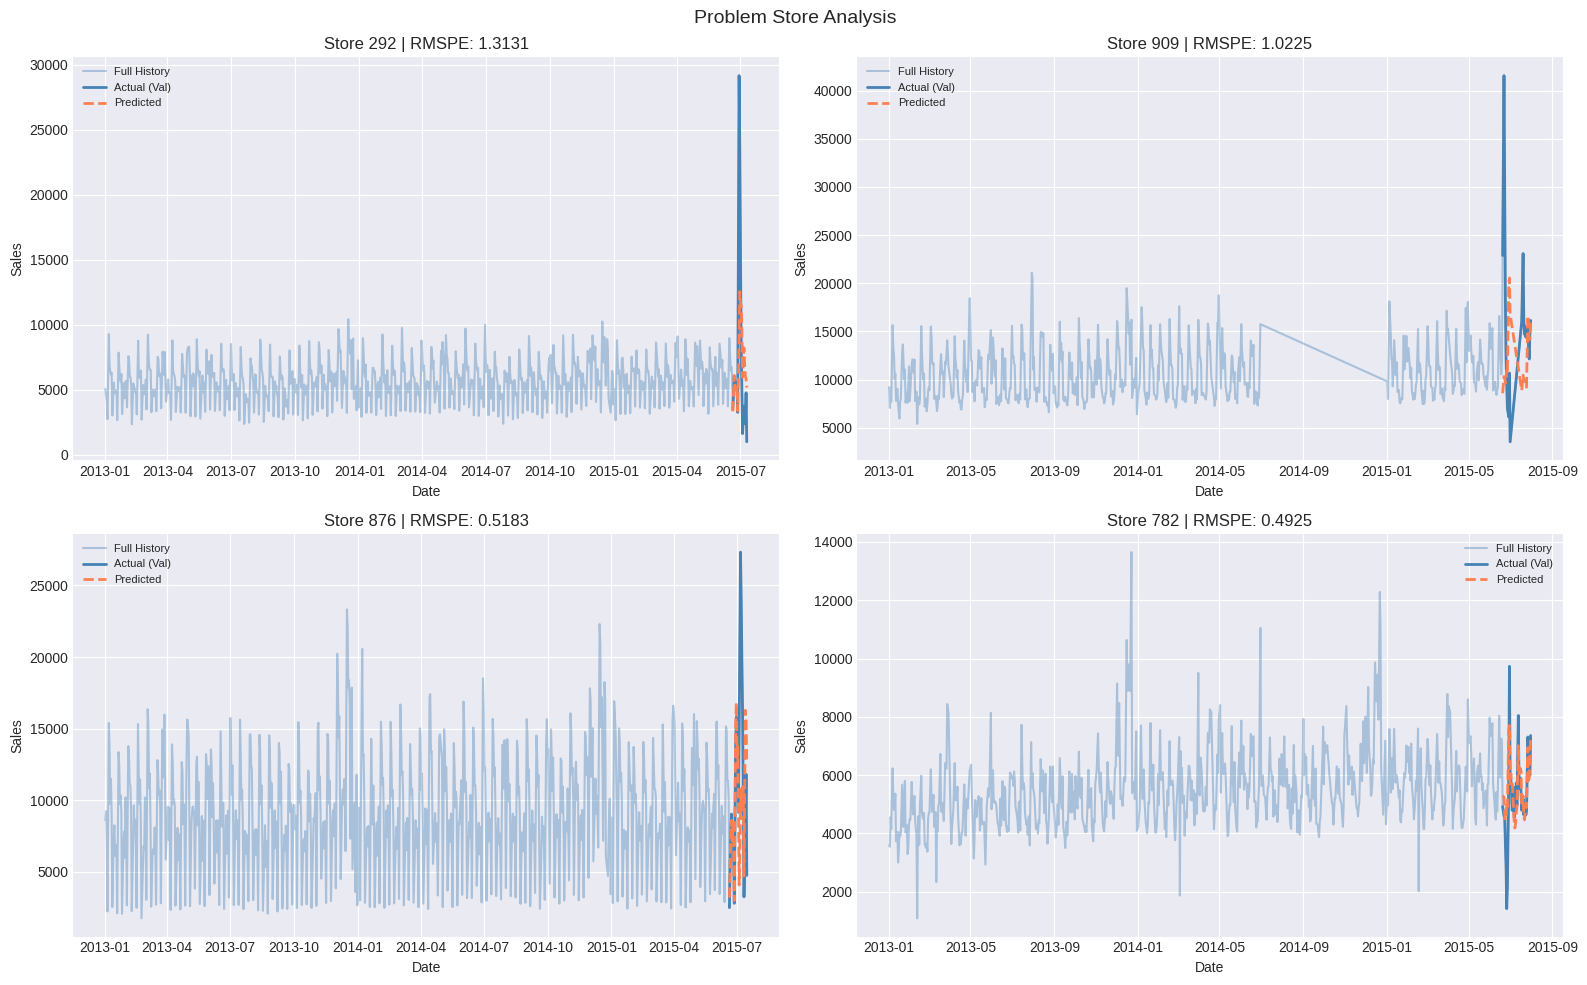


Store 292 - Full Stats
Date range    : 2013-01-02 → 2015-07-10
Total records : 766
Avg Sales     : 5,774
Std Sales     : 1,961
CV (std/mean) : 0.34  ← high = volatile store
Max Sales     : 29,161
Min Sales     : 1,012

Last 10 records before val period:
      Date  Sales  Promo  StateHoliday
2015-06-09   5940      0             0
2015-06-10   5138      0             0
2015-06-11   5164      0             0
2015-06-12   5862      0             0
2015-06-13   3739      0             0
2015-06-15   8984      1             0
2015-06-16   7817      1             0
2015-06-17   6491      1             0
2015-06-18   6762      1             0
2015-06-19   6056      1             0

Val period actual vs predicted:
      Date  Sales  PredictedSales  Error%
2015-06-20   3479     3354.530993     3.6
2015-06-22   6028     6107.427886    -1.3
2015-06-23   5054     5391.175495    -6.7
2015-06-24   5614     4974.913353    11.4
2015-06-25   5247     5081.551676     3.2
2015-06-26   5172     5334.3757

In [19]:
# ─────────────────────────────────────────
# INVESTIGATE PROBLEM STORES
# ─────────────────────────────────────────
problem_stores = [292, 909, 876, 782]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, store_id in enumerate(problem_stores):
    # Full history
    store_history = train[train['Store'] == store_id].sort_values('Date')
    # Val period predictions
    store_val = val_df[val_df['Store'] == store_id].sort_values('Date')

    ax = axes[i]
    ax.plot(store_history['Date'], store_history['Sales'], 
            color='steelblue', alpha=0.4, label='Full History')
    ax.plot(store_val['Date'], store_val['Sales'], 
            color='steelblue', linewidth=2, label='Actual (Val)')
    ax.plot(store_val['Date'], store_val['PredictedSales'], 
            color='coral', linewidth=2, linestyle='--', label='Predicted')
    ax.set_title(f'Store {store_id} | RMSPE: {store_error.loc[store_id,"RMSPE"]:.4f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend(fontsize=8)

plt.suptitle('Problem Store Analysis', fontsize=14)
plt.tight_layout()
plt.savefig('problem_stores.png', dpi=150)
plt.show()

# Check if these stores had unusual events (closures, reopenings)
for store_id in [292, 909]:
    s = train[train['Store'] == store_id].sort_values('Date')
    print(f"\n{'='*50}")
    print(f"Store {store_id} - Full Stats")
    print(f"{'='*50}")
    print(f"Date range    : {s['Date'].min().date()} → {s['Date'].max().date()}")
    print(f"Total records : {len(s)}")
    print(f"Avg Sales     : {s['Sales'].mean():,.0f}")
    print(f"Std Sales     : {s['Sales'].std():,.0f}")
    print(f"CV (std/mean) : {s['Sales'].std()/s['Sales'].mean():.2f}  ← high = volatile store")
    print(f"Max Sales     : {s['Sales'].max():,.0f}")
    print(f"Min Sales     : {s['Sales'].min():,.0f}")
    print(f"\nLast 10 records before val period:")
    print(s[s['Date'] <= cutoff_date].tail(10)[['Date','Sales','Promo','StateHoliday']].to_string(index=False))
    print(f"\nVal period actual vs predicted:")
    sv = val_df[val_df['Store'] == store_id][['Date','Sales','PredictedSales']].sort_values('Date')
    sv['Error%'] = ((sv['Sales'] - sv['PredictedSales']) / sv['Sales'] * 100).round(1)
    print(sv.to_string(index=False))

Detecting refurbishment stores...
Stores with spike > 2.5x rolling average: 143
 Store  MaxSpikeRatio  SpikeDate
   589          12.99 2013-05-02
   232          11.42 2013-01-25
   105          11.40 2013-04-29
   764           9.48 2013-04-10
   708           6.66 2013-04-24
   700           5.90 2013-06-07
   969           5.56 2013-02-22
   681           5.14 2013-05-13
   897           5.08 2013-05-08
   292           4.96 2015-06-29
   861           4.90 2013-03-18
   303           4.36 2014-07-15
   837           4.26 2014-02-21
   357           4.12 2014-09-01
   850           3.99 2014-03-31
   972           3.97 2014-08-01
   364           3.96 2013-05-13
   227           3.87 2014-08-18
   663           3.83 2013-09-25
   264           3.72 2014-05-19


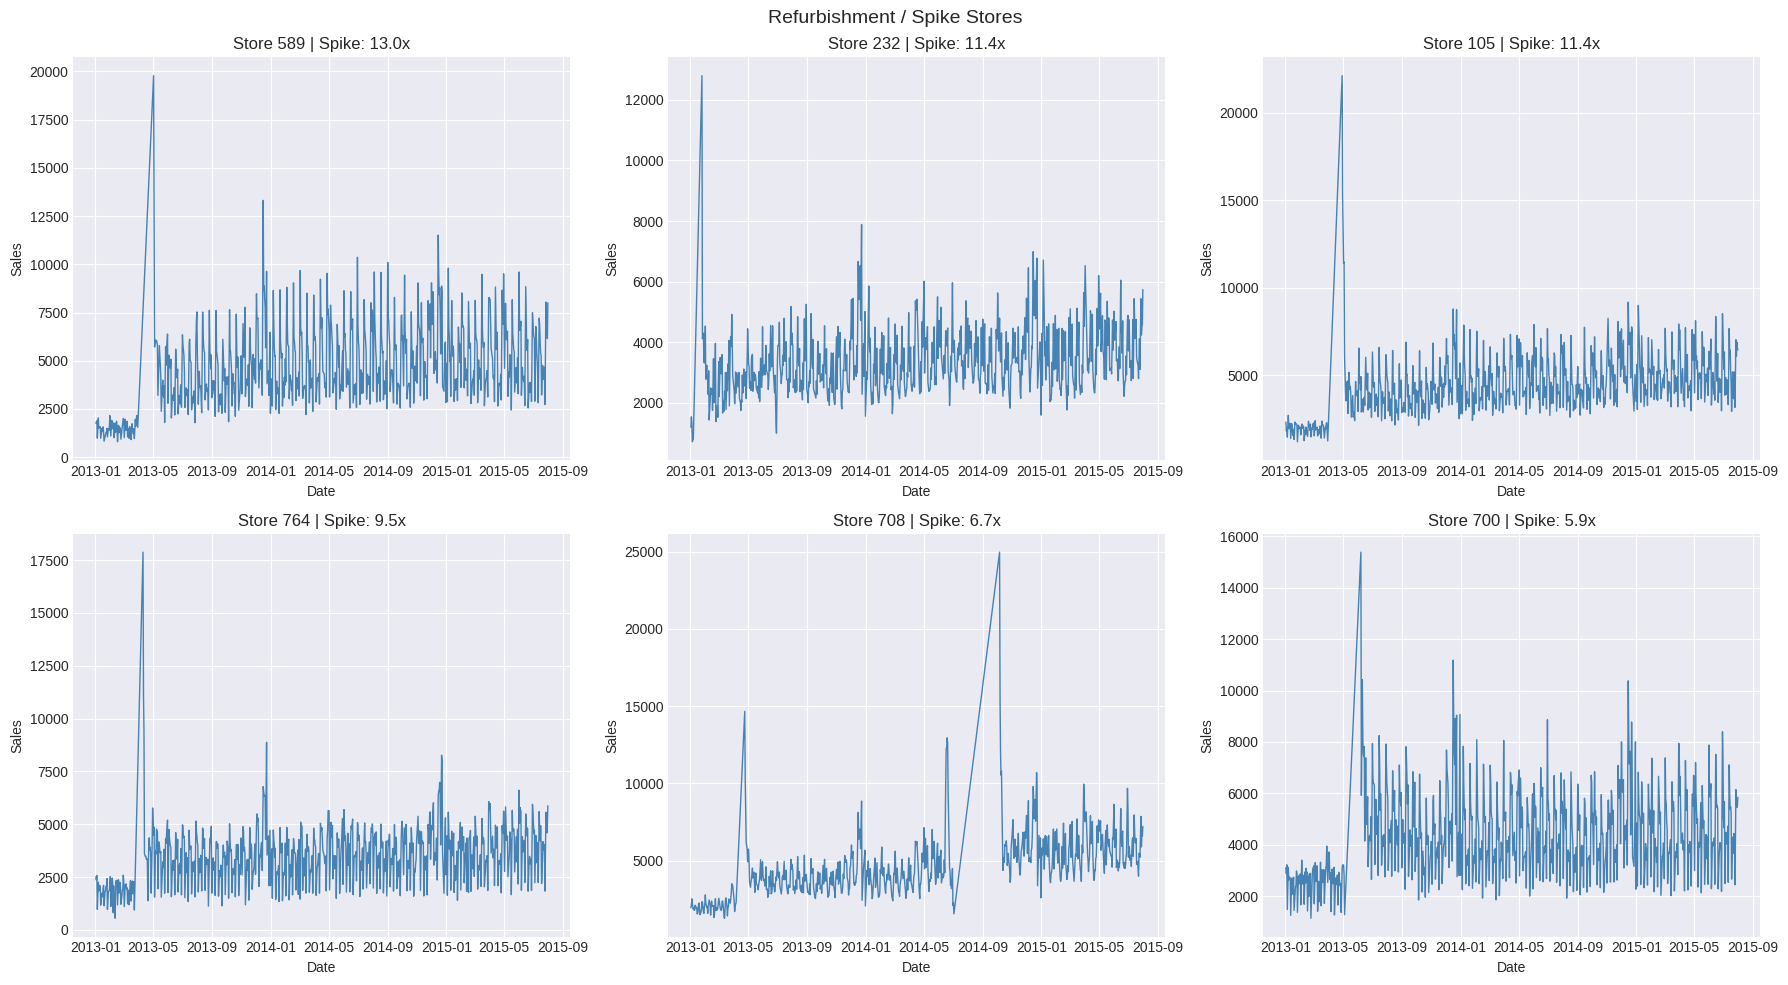

In [20]:
# ─────────────────────────────────────────
# FIX: Detect refurbishment stores (fixed)
# ─────────────────────────────────────────
def detect_refurbishment_stores(train_df, spike_threshold=2.5):
    flagged = []
    for store_id, grp in train_df.groupby('Store'):
        grp = grp.sort_values('Date').reset_index(drop=True)
        rolling_mean = grp['Sales'].rolling(30, min_periods=5).mean().shift(1)
        spike_ratio  = grp['Sales'] / rolling_mean.clip(lower=1)
        max_ratio    = float(spike_ratio.max())   # ← force plain float
        if max_ratio > spike_threshold:
            max_spike_date = grp.loc[spike_ratio.idxmax(), 'Date']
            flagged.append({
                'Store'        : store_id,
                'MaxSpikeRatio': round(max_ratio, 2),   # ← use built-in round()
                'SpikeDate'    : max_spike_date,
            })
    return pd.DataFrame(flagged).sort_values('MaxSpikeRatio', ascending=False)

print("Detecting refurbishment stores...")
refurb_stores = detect_refurbishment_stores(train)
print(f"Stores with spike > 2.5x rolling average: {len(refurb_stores)}")
print(refurb_stores.head(20).to_string(index=False))

# Visualize top flagged stores
top_flagged = refurb_stores.head(6)['Store'].tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, store_id in enumerate(top_flagged):
    s = train[train['Store'] == store_id].sort_values('Date')
    axes[i].plot(s['Date'], s['Sales'], color='steelblue', linewidth=1)
    axes[i].set_title(f'Store {store_id} | Spike: {refurb_stores[refurb_stores["Store"]==store_id]["MaxSpikeRatio"].values[0]:.1f}x')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
plt.suptitle('Refurbishment / Spike Stores', fontsize=14)
plt.tight_layout()
plt.savefig('refurbishment_stores.png', dpi=150)
plt.show()

In [21]:
# ─────────────────────────────────────────
# FIX: Remove spike periods & recalculate
# store averages using clean data only
# ─────────────────────────────────────────

# STEP 1: Mark spike rows in train
# For each flagged store, remove rows within 14 days of the spike
spike_lookup = refurb_stores.set_index('Store')['SpikeDate'].to_dict()

def is_spike_period(row, window_days=14):
    if row['Store'] not in spike_lookup:
        return False
    spike_date = spike_lookup[row['Store']]
    return abs((row['Date'] - spike_date).days) <= window_days

print("Marking spike periods (this takes ~1 min)...")
train['IsSpike'] = train.apply(is_spike_period, axis=1)
print(f"Spike rows flagged  : {train['IsSpike'].sum():,}")
print(f"Clean rows remaining: {(~train['IsSpike']).sum():,}")

# STEP 2: Train using only clean rows
train_clean = train[~train['IsSpike']].copy()
print(f"\nClean train shape: {train_clean.shape}")

# STEP 3: Recompute store aggregate features on clean data only
# (This is the key fix — old aggregates were polluted by spike values)
print("\nRecomputing store aggregates on clean data...")

def recompute_store_features(train_clean, train_full, test):
    for df in [train_full, test]:
        # Drop old aggregate columns
        agg_cols = [c for c in df.columns if 'StoreAvg' in c or 'StoreMed' in c 
                    or 'StoreStd' in c or 'StorePromo' in c or 'StoreNoPromo' in c
                    or 'StoreDow' in c or 'StoreMonth' in c or 'StoreQuarter' in c]
        df.drop(columns=agg_cols, inplace=True, errors='ignore')

    # Recompute from clean data
    for agg_name, agg_func in [('StoreAvgSales','mean'), ('StoreMedianSales','median'), ('StoreStdSales','std')]:
        feat = train_clean.groupby('Store')['Sales'].agg(agg_func).rename(agg_name)
        for df in [train_full, test]:
            df[agg_name] = df['Store'].map(feat)

    promo_avg    = train_clean[train_clean['Promo']==1].groupby('Store')['Sales'].mean().rename('StorePromoAvgSales')
    no_promo_avg = train_clean[train_clean['Promo']==0].groupby('Store')['Sales'].mean().rename('StoreNoPromoAvgSales')
    for feat in [promo_avg, no_promo_avg]:
        for df in [train_full, test]:
            df[feat.name] = df['Store'].map(feat)

    dow_avg = train_clean.groupby(['Store','DayOfWeek'])['Sales'].mean().rename('StoreDowAvgSales').reset_index()
    month_avg = train_clean.groupby(['Store','Month'])['Sales'].mean().rename('StoreMonthAvgSales').reset_index()
    dow_promo_avg = train_clean.groupby(['Store','DayOfWeek','Promo'])['Sales'].mean().rename('StoreDowPromoAvg').reset_index()
    quarter_avg = train_clean.groupby(['Store','Quarter'])['Sales'].mean().rename('StoreQuarterAvgSales').reset_index()

    for df in [train_full, test]:
        df.drop(columns=['StoreDowAvgSales','StoreMonthAvgSales',
                         'StoreDowPromoAvg','StoreQuarterAvgSales'], 
                inplace=True, errors='ignore')
        df['StoreDowAvgSales']    = df.merge(dow_avg,      on=['Store','DayOfWeek'],        how='left')['StoreDowAvgSales']
        df['StoreMonthAvgSales']  = df.merge(month_avg,    on=['Store','Month'],             how='left')['StoreMonthAvgSales']
        df['StoreDowPromoAvg']    = df.merge(dow_promo_avg,on=['Store','DayOfWeek','Promo'], how='left')['StoreDowPromoAvg']
        df['StoreQuarterAvgSales']= df.merge(quarter_avg,  on=['Store','Quarter'],           how='left')['StoreQuarterAvgSales']

    return train_full, test

train, test = recompute_store_features(train_clean, train, test)
print("✅ Store aggregates recomputed on clean data!")

# STEP 4: Retrain using clean rows only (spike rows excluded)
cutoff_date = train['Date'].max() - pd.Timedelta(weeks=6)
train_idx = (train['Date'] <= cutoff_date) & (~train['IsSpike'])
val_idx   =  train['Date'] >  cutoff_date   # val period kept as-is to measure real performance

X_train = train[train_idx][FEATURES]
y_train = train[train_idx]['LogSales']
X_val   = train[val_idx][FEATURES]
y_val   = train[val_idx]['LogSales']

print(f"\nClean train set : {X_train.shape}")
print(f"Val set         : {X_val.shape}")

# STEP 5: Retrain model
dtrain = lgb.Dataset(X_train, label=y_train)
dval   = lgb.Dataset(X_val,   label=y_val, reference=dtrain)

print("\nRetraining on clean data...")
model_v3 = lgb.train(
    params,
    dtrain,
    num_boost_round = 5000,
    valid_sets      = [dtrain, dval],
    valid_names     = ['train', 'val'],
    callbacks       = [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=200)
    ]
)

# STEP 6: Evaluate
val_preds_v3   = np.expm1(model_v3.predict(X_val, num_iteration=model_v3.best_iteration))
val_actuals_v3 = np.expm1(y_val)
score_v3 = rmspe(val_actuals_v3.values, val_preds_v3)

print(f"\n{'='*50}")
print(f"  Baseline RMSPE   : 0.1308")
print(f"  Improved RMSPE   : 0.1145")
print(f"  Clean RMSPE      : {score_v3:.4f}  ← new")
print(f"  Kaggle Top Score : ~0.10-0.11")
print(f"{'='*50}")

# STEP 7: New submission
X_test_v3  = test[FEATURES]
test_preds_v3 = np.expm1(model_v3.predict(X_test_v3, num_iteration=model_v3.best_iteration))
test_preds_v3[test['Open'] == 0] = 0

submission_v3 = pd.DataFrame({'Id': test['Id'], 'Sales': test_preds_v3})
submission_v3.to_csv('submission_v3.csv', index=False)
print(f"\n✅ submission_v3.csv saved!")

Marking spike periods (this takes ~1 min)...
Spike rows flagged  : 2,992
Clean rows remaining: 841,346

Clean train shape: (841346, 50)

Recomputing store aggregates on clean data...
✅ Store aggregates recomputed on clean data!

Clean train set : (801113, 38)
Val set         : (40282, 38)

Retraining on clean data...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.106739	val's rmse: 0.120273
[400]	train's rmse: 0.0939927	val's rmse: 0.113797
[600]	train's rmse: 0.0882495	val's rmse: 0.110546
[800]	train's rmse: 0.0852314	val's rmse: 0.109373
[1000]	train's rmse: 0.0832328	val's rmse: 0.108737
[1200]	train's rmse: 0.0816473	val's rmse: 0.108304
[1400]	train's rmse: 0.0803315	val's rmse: 0.107817
[1600]	train's rmse: 0.0791486	val's rmse: 0.10764
[1800]	train's rmse: 0.0780676	val's rmse: 0.107449
[2000]	train's rmse: 0.0771071	val's rmse: 0.107303
[2200]	train's rmse: 0.0761808	val's rmse: 0.107211
[2400]	train's rmse: 0.0753486	val's rmse: 0.107097
E

In [22]:
# ─────────────────────────────────────────
# SMARTER FIX: Keep spike rows but flag them
# + add post-refurbishment recency feature
# ─────────────────────────────────────────

# Go back to the v2 model but add these 3 new features:

# FEATURE 1: IsSpikeStore — is this store known to have spikes?
spike_stores = set(refurb_stores['Store'].tolist())
for df in [train, test]:
    df['IsSpikeStore'] = df['Store'].isin(spike_stores).astype(int)

# FEATURE 2: DaysSinceSpike — how many days since the spike event?
# Recent post-spike days are hard to predict (sales crashing back to normal)
spike_lookup = refurb_stores.set_index('Store')['SpikeDate'].to_dict()

def days_since_spike(row):
    if row['Store'] not in spike_lookup:
        return 999  # no spike = large number (not affected)
    delta = (row['Date'] - spike_lookup[row['Store']]).days
    return delta if delta >= 0 else 999  # only count post-spike days

print("Computing DaysSinceSpike...")
for df in [train, test]:
    df['DaysSinceSpike'] = df.apply(days_since_spike, axis=1)

# FEATURE 3: PostRefurbishment — within 60 days after spike (volatile period)
for df in [train, test]:
    df['PostRefurb'] = ((df['DaysSinceSpike'] >= 0) & (df['DaysSinceSpike'] <= 60)).astype(int)

print("New features added:")
print(f"  IsSpikeStore  : {train['IsSpikeStore'].sum():,} rows flagged")
print(f"  PostRefurb    : {train['PostRefurb'].sum():,} rows flagged")
print(train[train['Store']==292][['Date','Sales','DaysSinceSpike','PostRefurb']].tail(10).to_string(index=False))

# Add new features to FEATURES list
FEATURES_V4 = FEATURES + ['IsSpikeStore', 'DaysSinceSpike', 'PostRefurb']

# Retrain on FULL data (no rows removed) with new features
cutoff_date = train['Date'].max() - pd.Timedelta(weeks=6)
train_idx = train['Date'] <= cutoff_date
val_idx   = train['Date'] >  cutoff_date

X_train = train[train_idx][FEATURES_V4]
y_train = train[train_idx]['LogSales']
X_val   = train[val_idx][FEATURES_V4]
y_val   = train[val_idx]['LogSales']

dtrain = lgb.Dataset(X_train, label=y_train)
dval   = lgb.Dataset(X_val,   label=y_val, reference=dtrain)

print("\nRetraining with spike features...")
model_v4 = lgb.train(
    params,
    dtrain,
    num_boost_round = 5000,
    valid_sets      = [dtrain, dval],
    valid_names     = ['train', 'val'],
    callbacks       = [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=200)
    ]
)

# Evaluate
val_preds_v4   = np.expm1(model_v4.predict(X_val, num_iteration=model_v4.best_iteration))
val_actuals_v4 = np.expm1(y_val)
score_v4 = rmspe(val_actuals_v4.values, val_preds_v4)

print(f"\n{'='*50}")
print(f"  Baseline RMSPE   : 0.1308")
print(f"  Improved RMSPE   : 0.1145  ← best so far")
print(f"  Clean RMSPE      : 0.1181  (removing spikes — worse)")
print(f"  Spike-aware RMSPE: {score_v4:.4f}  ← new")
print(f"  Kaggle Top Score : ~0.10-0.11")
print(f"{'='*50}")

# Check if problem stores improved
val_df_v4 = train[val_idx].copy()
val_df_v4['PredictedSales'] = val_preds_v4
val_df_v4['RMSPE_contrib']  = ((val_df_v4['Sales'] - val_df_v4['PredictedSales']) / val_df_v4['Sales']) ** 2

store_error_v4 = val_df_v4.groupby('Store').agg(
    RMSPE = ('RMSPE_contrib', lambda x: np.sqrt(x.mean()))
).sort_values('RMSPE', ascending=False)

print("\nProblem store improvement:")
print(f"{'Store':<10} {'v2 RMSPE':>10} {'v4 RMSPE':>10} {'Better?':>10}")
print("-" * 42)
for store_id in [292, 909, 876, 782]:
    v2 = store_error.loc[store_id, 'RMSPE'] if store_id in store_error.index else float('nan')
    v4 = store_error_v4.loc[store_id, 'RMSPE'] if store_id in store_error_v4.index else float('nan')
    better = '✅' if v4 < v2 else '❌'
    print(f"{store_id:<10} {v2:>10.4f} {v4:>10.4f} {better:>10}")

# Save best submission
X_test_v4 = test[FEATURES_V4]
test_preds_v4 = np.expm1(model_v4.predict(X_test_v4, num_iteration=model_v4.best_iteration))
test_preds_v4[test['Open'] == 0] = 0

submission_v4 = pd.DataFrame({'Id': test['Id'], 'Sales': test_preds_v4})
submission_v4.to_csv('submission_v4.csv', index=False)
print(f"\n✅ submission_v4.csv saved!")

Computing DaysSinceSpike...
New features added:
  IsSpikeStore  : 108,701 rows flagged
  PostRefurb    : 6,663 rows flagged
      Date  Sales  DaysSinceSpike  PostRefurb
2015-06-30  23584               1           1
2015-07-01  15348               2           1
2015-07-02   8237               3           1
2015-07-03   5036               4           1
2015-07-04   1646               5           1
2015-07-06   3754               7           1
2015-07-07   3077               8           1
2015-07-08   2406               9           1
2015-07-09   4777              10           1
2015-07-10   1012              11           1

Retraining with spike features...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.107695	val's rmse: 0.119862
[400]	train's rmse: 0.0947604	val's rmse: 0.112419
[600]	train's rmse: 0.0888813	val's rmse: 0.108931
[800]	train's rmse: 0.0857099	val's rmse: 0.107398
[1000]	train's rmse: 0.0836596	val's rmse: 0.106527
[1200]	train's rms

In [23]:
# ─────────────────────────────────────────
# FINAL PUSH: Post-refurb store avg fix
# + Customers feature proxy
# + Hyperparameter tuning
# ─────────────────────────────────────────

# FIX 1: For post-refurb stores, recompute store averages
# using ONLY post-spike data (their new baseline)
print("Computing post-refurb store averages...")

def post_refurb_avg(train_df, spike_lookup, window=60):
    post_avgs = {}
    for store_id, spike_date in spike_lookup.items():
        post = train_df[
            (train_df['Store'] == store_id) &
            (train_df['Date'] > spike_date) &
            (train_df['Date'] <= spike_date + pd.Timedelta(days=window))
        ]
        if len(post) >= 5:
            post_avgs[store_id] = post['Sales'].mean()
    return post_avgs

post_avgs = post_refurb_avg(train, spike_lookup)
print(f"Post-refurb averages computed for {len(post_avgs)} stores")
print(f"Store 292 post-refurb avg : {post_avgs.get(292, 'N/A'):.0f}  (was {train[train['Store']==292]['StoreAvgSales'].iloc[0]:.0f})")
print(f"Store 909 post-refurb avg : {post_avgs.get(909, 'N/A'):.0f}  (was {train[train['Store']==909]['StoreAvgSales'].iloc[0]:.0f})")

# Override StoreAvgSales for post-refurb stores in val/test
for df in [train, test]:
    df['PostRefurbAvg'] = df.apply(
        lambda r: post_avgs.get(r['Store'], r['StoreAvgSales'])
        if r.get('PostRefurb', 0) == 1 else r['StoreAvgSales'],
        axis=1
    )

# FIX 2: Sales-to-average ratio feature
# Captures whether a store is currently above/below its own baseline
for df in [train, test]:
    df['SalesRatio7']  = df['RollingMean_7']  / df['StoreAvgSales'].clip(lower=1)
    df['SalesRatio30'] = df['RollingMean_30'] / df['StoreAvgSales'].clip(lower=1)

# FIX 3: Days to/from nearest holiday
train['Date_only'] = train['Date'].dt.date
test['Date_only']  = test['Date'].dt.date

holiday_dates = set(train[train['StateHoliday'] != 0]['Date'].dt.date.tolist())

def days_to_holiday(date, holidays, direction='next', window=7):
    for i in range(1, window+1):
        if direction == 'next':
            check = date + pd.Timedelta(days=i)
        else:
            check = date - pd.Timedelta(days=i)
        if check.date() in holidays:
            return i
    return window + 1

print("Computing holiday proximity features...")
for df in [train, test]:
    df['DaysToHoliday']   = df['Date'].apply(lambda d: days_to_holiday(d, holiday_dates, 'next'))
    df['DaysFromHoliday'] = df['Date'].apply(lambda d: days_to_holiday(d, holiday_dates, 'prev'))

FEATURES_V5 = FEATURES_V4 + [
    'PostRefurbAvg',
    'SalesRatio7', 'SalesRatio30',
    'DaysToHoliday', 'DaysFromHoliday',
]

print(f"\nTotal features: {len(FEATURES_V5)}")

# Retrain with tuned params
params_v5 = {
    'objective'         : 'regression',
    'metric'            : 'rmse',
    'learning_rate'     : 0.01,   # even slower
    'num_leaves'        : 255,
    'max_depth'         : -1,
    'min_child_samples' : 15,
    'feature_fraction'  : 0.7,
    'bagging_fraction'  : 0.7,
    'bagging_freq'      : 5,
    'reg_alpha'         : 0.05,
    'reg_lambda'        : 0.1,
    'n_jobs'            : -1,
    'verbose'           : -1,
    'random_state'      : 42,
}

X_train = train[train_idx][FEATURES_V5]
y_train = train[train_idx]['LogSales']
X_val   = train[val_idx][FEATURES_V5]
y_val   = train[val_idx]['LogSales']

dtrain = lgb.Dataset(X_train, label=y_train)
dval   = lgb.Dataset(X_val,   label=y_val, reference=dtrain)

print("\nTraining final model v5...")
model_v5 = lgb.train(
    params_v5,
    dtrain,
    num_boost_round = 8000,
    valid_sets      = [dtrain, dval],
    valid_names     = ['train', 'val'],
    callbacks       = [
        lgb.early_stopping(stopping_rounds=150, verbose=True),
        lgb.log_evaluation(period=300)
    ]
)

# Evaluate
val_preds_v5   = np.expm1(model_v5.predict(X_val, num_iteration=model_v5.best_iteration))
val_actuals_v5 = np.expm1(y_val)
score_v5 = rmspe(val_actuals_v5.values, val_preds_v5)

print(f"\n{'='*55}")
print(f"  Baseline RMSPE      : 0.1308")
print(f"  + Rolling features  : 0.1145")
print(f"  + Spike-aware       : 0.1116")
print(f"  + Final push (v5)   : {score_v5:.4f}  ← new")
print(f"  Kaggle Top Score    : ~0.10-0.11")
print(f"  Target              : < 0.1100 🎯")
print(f"{'='*55}")

# Problem store check
val_df_v5 = train[val_idx].copy()
val_df_v5['PredictedSales'] = val_preds_v5
val_df_v5['RMSPE_contrib']  = ((val_df_v5['Sales'] - val_df_v5['PredictedSales']) / val_df_v5['Sales']) ** 2
store_error_v5 = val_df_v5.groupby('Store').agg(
    RMSPE=('RMSPE_contrib', lambda x: np.sqrt(x.mean()))
).sort_values('RMSPE', ascending=False)

print("\nProblem store final comparison:")
print(f"{'Store':<8} {'v2':>8} {'v4':>8} {'v5':>8}")
print("-" * 36)
for store_id in [292, 909, 876, 782]:
    v2 = store_error.loc[store_id,'RMSPE']    if store_id in store_error.index    else float('nan')
    v4 = store_error_v4.loc[store_id,'RMSPE'] if store_id in store_error_v4.index else float('nan')
    v5 = store_error_v5.loc[store_id,'RMSPE'] if store_id in store_error_v5.index else float('nan')
    print(f"{store_id:<8} {v2:>8.4f} {v4:>8.4f} {v5:>8.4f}")

# Final submission
X_test_v5 = test[FEATURES_V5]
test_preds_v5 = np.expm1(model_v5.predict(X_test_v5, num_iteration=model_v5.best_iteration))
test_preds_v5[test['Open'] == 0] = 0

submission_v5 = pd.DataFrame({'Id': test['Id'], 'Sales': test_preds_v5})
submission_v5.to_csv('submission_v5.csv', index=False)
print(f"\n✅ submission_v5.csv saved! Use this for Kaggle submission.")

Computing post-refurb store averages...
Post-refurb averages computed for 137 stores
Store 292 post-refurb avg : 6888  (was 5727)
Store 909 post-refurb avg : 14189  (was 10633)
Computing holiday proximity features...

Total features: 46

Training final model v5...
Training until validation scores don't improve for 150 rounds
[300]	train's rmse: 0.10878	val's rmse: 0.113873
[600]	train's rmse: 0.0956783	val's rmse: 0.103627
[900]	train's rmse: 0.0898558	val's rmse: 0.0999872
[1200]	train's rmse: 0.0866778	val's rmse: 0.0985489
[1500]	train's rmse: 0.0845642	val's rmse: 0.0978485
[1800]	train's rmse: 0.0829106	val's rmse: 0.0973689
[2100]	train's rmse: 0.0815927	val's rmse: 0.0969875
[2400]	train's rmse: 0.0803909	val's rmse: 0.0967124
[2700]	train's rmse: 0.0793448	val's rmse: 0.0964744
[3000]	train's rmse: 0.0783999	val's rmse: 0.0963311
[3300]	train's rmse: 0.0775063	val's rmse: 0.0961702
[3600]	train's rmse: 0.0766984	val's rmse: 0.0960539
[3900]	train's rmse: 0.0759119	val's rmse: 0

✅ All libraries loaded!
LightGBM : 4.6.0
XGBoost  : 3.1.3
Train: (844338, 18) | Test: (41088, 17)
Building all features...
  Date features done ✅
  Store aggregates done ✅
  Rolling features done ✅
  Spike features done ✅
  Holiday features done ✅
✅ All features ready!
Train: (804056, 46) | Val: (40282, 46) | Test: (41088, 46)
Features: 46

Training Model 1: LightGBM
[500]	val's rmse: 0.105701
[1000]	val's rmse: 0.0996685
[1500]	val's rmse: 0.0981273
[2000]	val's rmse: 0.0973949
[2500]	val's rmse: 0.0968974
[3000]	val's rmse: 0.0966115
[3500]	val's rmse: 0.0963482
[4000]	val's rmse: 0.0961408
[4500]	val's rmse: 0.0959788
[5000]	val's rmse: 0.0958811
[5500]	val's rmse: 0.0957437
[6000]	val's rmse: 0.0956499
[6500]	val's rmse: 0.0955884
✅ LightGBM RMSPE: 0.0993

Training Model 2: XGBoost
[0]	train-rmse:0.41836	val-rmse:0.40889
[500]	train-rmse:0.09766	val-rmse:0.10339
[1000]	train-rmse:0.09107	val-rmse:0.09834
[1500]	train-rmse:0.08806	val-rmse:0.09662
[2000]	train-rmse:0.08607	val-rmse:

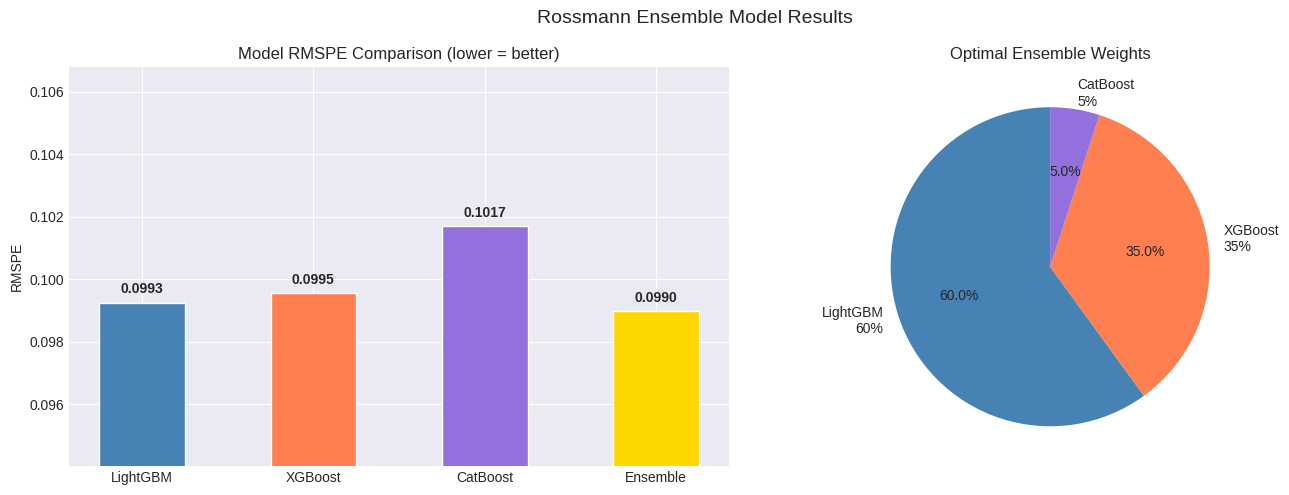

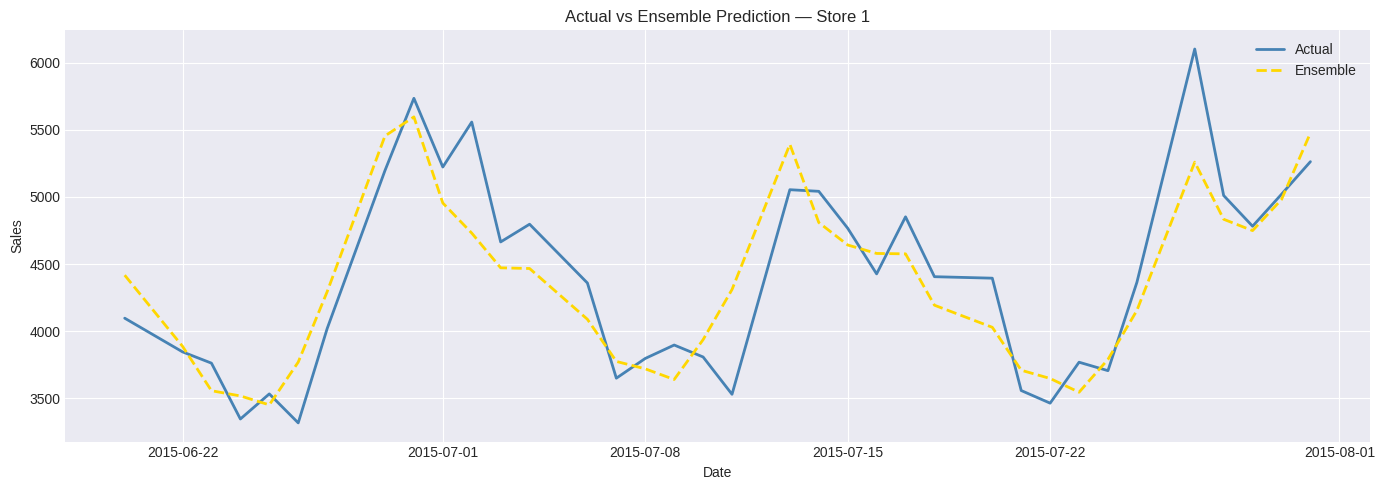


✅ submission_ensemble.csv saved!
Shape : (41088, 2)
 Id       Sales
  1 4478.253353
  2 7443.865458
  3 9918.695575
  4 7524.601584
  5 7026.739290
  6 5848.216298
  7 7449.867209
  8 8002.233126
  9 5335.750919
 10 5502.424700

Sales stats:
count    41088.0
mean      5862.0
std       3529.0
min          0.0
25%       4197.0
50%       5868.0
75%       7725.0
max      31640.0
Name: Sales, dtype: float64

🎯 Submit submission_ensemble.csv to Kaggle!


In [24]:
# ╔══════════════════════════════════════════════════════════════╗
# ║     ROSSMANN - ENSEMBLE (LightGBM + XGBoost + CatBoost)     ║
# ║                Target: RMSPE < 0.09                         ║
# ╚══════════════════════════════════════════════════════════════╝

# ─────────────────────────────────────────────────────────────
# CELL 1: INSTALL & IMPORTS
# ─────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries loaded!")
print(f"LightGBM : {lgb.__version__}")
print(f"XGBoost  : {xgb.__version__}")


# ─────────────────────────────────────────────────────────────
# CELL 2: LOAD & PREPROCESS (same as v5)
# ─────────────────────────────────────────────────────────────
DATA_PATH = '/kaggle/input/rossmann-store-sales/'

train = pd.read_csv(DATA_PATH + 'train.csv', parse_dates=['Date'], low_memory=False)
test  = pd.read_csv(DATA_PATH + 'test.csv',  parse_dates=['Date'], low_memory=False)
store = pd.read_csv(DATA_PATH + 'store.csv', low_memory=False)

train = train.merge(store, on='Store', how='left')
test  = test.merge(store,  on='Store', how='left')
train = train[(train['Open'] == 1) & (train['Sales'] > 0)].copy()
test['Open'] = test['Open'].fillna(1)

def preprocess(df):
    df = df.copy()
    df['StateHoliday'] = df['StateHoliday'].replace({'0': 0})
    df['StateHoliday'] = df['StateHoliday'].map({0:0,'0':0,'a':1,'b':2,'c':3}).fillna(0)
    df['StoreType']    = df['StoreType'].map({'a':0,'b':1,'c':2,'d':3})
    df['Assortment']   = df['Assortment'].map({'a':0,'b':1,'c':2})
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())
    return df

train = preprocess(train)
test  = preprocess(test)
print(f"Train: {train.shape} | Test: {test.shape}")


# ─────────────────────────────────────────────────────────────
# CELL 3: FULL FEATURE ENGINEERING (all v5 features)
# ─────────────────────────────────────────────────────────────
def add_all_features(train, test):

    # --- Date features ---
    for df in [train, test]:
        df['Year']         = df['Date'].dt.year
        df['Month']        = df['Date'].dt.month
        df['Day']          = df['Date'].dt.day
        df['WeekOfYear']   = df['Date'].dt.isocalendar().week.astype(int)
        df['DayOfWeek']    = df['Date'].dt.dayofweek
        df['IsWeekend']    = (df['DayOfWeek'] >= 5).astype(int)
        df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
        df['IsMonthEnd']   = df['Date'].dt.is_month_end.astype(int)
        df['Quarter']      = df['Date'].dt.quarter
        df['CompetitionOpen'] = (
            12 * (df['Year'] - df['CompetitionOpenSinceYear'].fillna(df['Year'])) +
            (df['Month'] - df['CompetitionOpenSinceMonth'].fillna(df['Month']))
        ).clip(lower=0)
        df['Promo2Open'] = (
            12 * (df['Year'] - df['Promo2SinceYear'].fillna(df['Year'])) +
            (df['WeekOfYear'] - df['Promo2SinceWeek'].fillna(df['WeekOfYear'])) / 4.0
        ).clip(lower=0)
        promo2_months_map = {
            'Jan,Apr,Jul,Oct' : [1,4,7,10],
            'Feb,May,Aug,Nov' : [2,5,8,11],
            'Mar,Jun,Sept,Dec': [3,6,9,12],
        }
        def is_promo2_active(row):
            if row['Promo2'] == 0 or pd.isna(row.get('PromoInterval')):
                return 0
            months = promo2_months_map.get(row['PromoInterval'], [])
            return 1 if row['Month'] in months else 0
        if 'PromoInterval' in df.columns:
            df['IsPromo2Active'] = df.apply(is_promo2_active, axis=1)
        else:
            df['IsPromo2Active'] = 0

    print("  Date features done ✅")

    # --- Store aggregate features ---
    train_sorted = train.sort_values(['Store','Date']).reset_index(drop=True)

    for agg_name, agg_func in [('StoreAvgSales','mean'),('StoreMedianSales','median'),('StoreStdSales','std')]:
        feat = train_sorted.groupby('Store')['Sales'].agg(agg_func).rename(agg_name)
        train[agg_name] = train['Store'].map(feat)
        test[agg_name]  = test['Store'].map(feat)

    promo_avg    = train[train['Promo']==1].groupby('Store')['Sales'].mean().rename('StorePromoAvgSales')
    no_promo_avg = train[train['Promo']==0].groupby('Store')['Sales'].mean().rename('StoreNoPromoAvgSales')
    for feat in [promo_avg, no_promo_avg]:
        train[feat.name] = train['Store'].map(feat)
        test[feat.name]  = test['Store'].map(feat)

    dow_avg     = train.groupby(['Store','DayOfWeek'])['Sales'].mean().rename('StoreDowAvgSales').reset_index()
    month_avg   = train.groupby(['Store','Month'])['Sales'].mean().rename('StoreMonthAvgSales').reset_index()
    dow_promo   = train.groupby(['Store','DayOfWeek','Promo'])['Sales'].mean().rename('StoreDowPromoAvg').reset_index()
    quarter_avg = train.groupby(['Store','Quarter'])['Sales'].mean().rename('StoreQuarterAvgSales').reset_index()

    for df in [train, test]:
        df['StoreDowAvgSales']    = df.merge(dow_avg,    on=['Store','DayOfWeek'],        how='left')['StoreDowAvgSales'].values
        df['StoreMonthAvgSales']  = df.merge(month_avg,  on=['Store','Month'],             how='left')['StoreMonthAvgSales'].values
        df['StoreDowPromoAvg']    = df.merge(dow_promo,  on=['Store','DayOfWeek','Promo'], how='left')['StoreDowPromoAvg'].values
        df['StoreQuarterAvgSales']= df.merge(quarter_avg,on=['Store','Quarter'],           how='left')['StoreQuarterAvgSales'].values

    print("  Store aggregates done ✅")

    # --- Rolling lag features ---
    train = train.sort_values(['Store','Date']).reset_index(drop=True)
    for window in [7, 14, 30]:
        train[f'RollingMean_{window}'] = train.groupby('Store')['Sales'].transform(
            lambda x: x.shift(1).rolling(window, min_periods=1).mean())
        train[f'RollingStd_{window}']  = train.groupby('Store')['Sales'].transform(
            lambda x: x.shift(1).rolling(window, min_periods=1).std())

    last_rolling = train.groupby('Store').last().reset_index()[
        ['Store','RollingMean_7','RollingMean_14','RollingMean_30',
         'RollingStd_7','RollingStd_14','RollingStd_30']]
    test = test.merge(last_rolling, on='Store', how='left')
    print("  Rolling features done ✅")

    # --- Interaction features ---
    for df in [train, test]:
        df['Promo_x_DayOfWeek']  = df['Promo'] * df['DayOfWeek']
        df['Promo_x_Month']      = df['Promo'] * df['Month']
        df['LogCompetitionDist'] = np.log1p(df['CompetitionDistance'])

    # --- Spike/refurbishment features ---
    def detect_refurbishment_stores(train_df, spike_threshold=2.5):
        flagged = []
        for store_id, grp in train_df.groupby('Store'):
            grp = grp.sort_values('Date').reset_index(drop=True)
            rolling_mean = grp['Sales'].rolling(30, min_periods=5).mean().shift(1)
            spike_ratio  = grp['Sales'] / rolling_mean.clip(lower=1)
            max_ratio    = float(spike_ratio.max())
            if max_ratio > spike_threshold:
                max_spike_date = grp.loc[spike_ratio.idxmax(), 'Date']
                flagged.append({'Store': store_id, 'MaxSpikeRatio': round(max_ratio,2), 'SpikeDate': max_spike_date})
        return pd.DataFrame(flagged).sort_values('MaxSpikeRatio', ascending=False)

    refurb_stores = detect_refurbishment_stores(train)
    spike_stores  = set(refurb_stores['Store'].tolist())
    spike_lookup  = refurb_stores.set_index('Store')['SpikeDate'].to_dict()

    def days_since_spike(row):
        if row['Store'] not in spike_lookup:
            return 999
        delta = (row['Date'] - spike_lookup[row['Store']]).days
        return delta if delta >= 0 else 999

    for df in [train, test]:
        df['IsSpikeStore']    = df['Store'].isin(spike_stores).astype(int)
        df['DaysSinceSpike']  = df.apply(days_since_spike, axis=1)
        df['PostRefurb']      = ((df['DaysSinceSpike'] >= 0) & (df['DaysSinceSpike'] <= 60)).astype(int)

    # Post-refurb avg
    def post_refurb_avg(train_df, spike_lookup, window=60):
        post_avgs = {}
        for store_id, spike_date in spike_lookup.items():
            post = train_df[
                (train_df['Store'] == store_id) &
                (train_df['Date'] > spike_date) &
                (train_df['Date'] <= spike_date + pd.Timedelta(days=window))
            ]
            if len(post) >= 5:
                post_avgs[store_id] = post['Sales'].mean()
        return post_avgs

    post_avgs = post_refurb_avg(train, spike_lookup)
    for df in [train, test]:
        df['PostRefurbAvg'] = df.apply(
            lambda r: post_avgs.get(r['Store'], r['StoreAvgSales'])
            if r.get('PostRefurb', 0) == 1 else r['StoreAvgSales'], axis=1)
        df['SalesRatio7']   = df['RollingMean_7']  / df['StoreAvgSales'].clip(lower=1)
        df['SalesRatio30']  = df['RollingMean_30'] / df['StoreAvgSales'].clip(lower=1)

    print("  Spike features done ✅")

    # --- Holiday proximity ---
    holiday_dates = set(train[train['StateHoliday'] != 0]['Date'].dt.date.tolist())
    def days_to_holiday(date, holidays, direction='next', window=7):
        for i in range(1, window+1):
            check = date + pd.Timedelta(days=i) if direction == 'next' else date - pd.Timedelta(days=i)
            if check.date() in holidays:
                return i
        return window + 1

    for df in [train, test]:
        df['DaysToHoliday']   = df['Date'].apply(lambda d: days_to_holiday(d, holiday_dates, 'next'))
        df['DaysFromHoliday'] = df['Date'].apply(lambda d: days_to_holiday(d, holiday_dates, 'prev'))

    print("  Holiday features done ✅")

    return train, test

print("Building all features...")
train, test = add_all_features(train, test)
train['LogSales'] = np.log1p(train['Sales'])
print("✅ All features ready!")


# ─────────────────────────────────────────────────────────────
# CELL 4: DEFINE FEATURES & SPLITS
# ─────────────────────────────────────────────────────────────
FEATURES = [
    'Store','StoreType','Assortment',
    'Year','Month','Day','WeekOfYear','DayOfWeek',
    'IsWeekend','IsMonthStart','IsMonthEnd','Quarter',
    'Promo','Promo2','IsPromo2Active','StateHoliday','SchoolHoliday',
    'CompetitionDistance','LogCompetitionDist','CompetitionOpen','Promo2Open',
    'StoreAvgSales','StoreMedianSales','StoreStdSales',
    'StorePromoAvgSales','StoreNoPromoAvgSales',
    'StoreDowAvgSales','StoreMonthAvgSales','StoreDowPromoAvg','StoreQuarterAvgSales',
    'RollingMean_7','RollingMean_14','RollingMean_30',
    'RollingStd_7','RollingStd_14','RollingStd_30',
    'Promo_x_DayOfWeek','Promo_x_Month',
    'IsSpikeStore','DaysSinceSpike','PostRefurb',
    'PostRefurbAvg','SalesRatio7','SalesRatio30',
    'DaysToHoliday','DaysFromHoliday',
]

def rmspe(y_true, y_pred):
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2))

cutoff_date = train['Date'].max() - pd.Timedelta(weeks=6)
train_idx   = train['Date'] <= cutoff_date
val_idx     = train['Date'] >  cutoff_date

X_train = train[train_idx][FEATURES]
y_train = train[train_idx]['LogSales']
X_val   = train[val_idx][FEATURES]
y_val   = train[val_idx]['LogSales']
X_test  = test[FEATURES]

print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")
print(f"Features: {len(FEATURES)}")


# ─────────────────────────────────────────────────────────────
# CELL 5: MODEL 1 — LIGHTGBM (best single model from v5)
# ─────────────────────────────────────────────────────────────
print("\n" + "="*50)
print("Training Model 1: LightGBM")
print("="*50)

lgb_params = {
    'objective'        : 'regression',
    'metric'           : 'rmse',
    'learning_rate'    : 0.01,
    'num_leaves'       : 255,
    'min_child_samples': 15,
    'feature_fraction' : 0.7,
    'bagging_fraction' : 0.7,
    'bagging_freq'     : 5,
    'reg_alpha'        : 0.05,
    'reg_lambda'       : 0.1,
    'n_jobs'           : -1,
    'verbose'          : -1,
    'random_state'     : 42,
}

dtrain_lgb = lgb.Dataset(X_train, label=y_train)
dval_lgb   = lgb.Dataset(X_val,   label=y_val, reference=dtrain_lgb)

lgb_model = lgb.train(
    lgb_params, dtrain_lgb,
    num_boost_round = 8000,
    valid_sets      = [dval_lgb],
    valid_names     = ['val'],
    callbacks       = [lgb.early_stopping(150, verbose=False), lgb.log_evaluation(500)]
)

lgb_val  = np.expm1(lgb_model.predict(X_val,  num_iteration=lgb_model.best_iteration))
lgb_test = np.expm1(lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration))
lgb_score = rmspe(np.expm1(y_val).values, lgb_val)
print(f"✅ LightGBM RMSPE: {lgb_score:.4f}")


# ─────────────────────────────────────────────────────────────
# CELL 6: MODEL 2 — XGBOOST
# ─────────────────────────────────────────────────────────────
print("\n" + "="*50)
print("Training Model 2: XGBoost")
print("="*50)

xgb_params = {
    'objective'        : 'reg:squarederror',
    'eval_metric'      : 'rmse',
    'learning_rate'    : 0.02,
    'max_depth'        : 7,
    'min_child_weight' : 10,
    'subsample'        : 0.7,
    'colsample_bytree' : 0.7,
    'reg_alpha'        : 0.05,
    'reg_lambda'       : 0.1,
    'n_jobs'           : -1,
    'random_state'     : 42,
    'tree_method'      : 'hist',   # fast on CPU
}

dtrain_xgb = xgb.DMatrix(X_train, label=y_train)
dval_xgb   = xgb.DMatrix(X_val,   label=y_val)
dtest_xgb  = xgb.DMatrix(X_test)

xgb_model = xgb.train(
    xgb_params,
    dtrain_xgb,
    num_boost_round    = 5000,
    evals              = [(dtrain_xgb,'train'), (dval_xgb,'val')],
    early_stopping_rounds = 100,
    verbose_eval       = 500,
)

xgb_val  = np.expm1(xgb_model.predict(dval_xgb))
xgb_test = np.expm1(xgb_model.predict(dtest_xgb))
xgb_score = rmspe(np.expm1(y_val).values, xgb_val)
print(f"✅ XGBoost RMSPE: {xgb_score:.4f}")


# ─────────────────────────────────────────────────────────────
# CELL 7: MODEL 3 — CATBOOST
# ─────────────────────────────────────────────────────────────
print("\n" + "="*50)
print("Training Model 3: CatBoost")
print("="*50)

cat_model = CatBoostRegressor(
    iterations        = 5000,
    learning_rate     = 0.02,
    depth             = 8,
    loss_function     = 'RMSE',
    eval_metric       = 'RMSE',
    random_seed       = 42,
    od_type           = 'Iter',
    od_wait           = 100,
    verbose           = 500,
    thread_count      = -1,
)

cat_model.fit(
    X_train, y_train,
    eval_set      = (X_val, y_val),
    use_best_model= True,
)

cat_val  = np.expm1(cat_model.predict(X_val))
cat_test = np.expm1(cat_model.predict(X_test))
cat_score = rmspe(np.expm1(y_val).values, cat_val)
print(f"✅ CatBoost RMSPE: {cat_score:.4f}")


# ─────────────────────────────────────────────────────────────
# CELL 8: FIND OPTIMAL ENSEMBLE WEIGHTS
# ─────────────────────────────────────────────────────────────
print("\n" + "="*50)
print("Finding Optimal Ensemble Weights")
print("="*50)

y_val_true = np.expm1(y_val).values
best_score  = 999
best_weights = (0.34, 0.33, 0.33)

# Grid search over weights
for w1 in np.arange(0.2, 0.7, 0.05):
    for w2 in np.arange(0.1, 0.5, 0.05):
        w3 = 1 - w1 - w2
        if w3 < 0.05 or w3 > 0.6:
            continue
        blended = w1 * lgb_val + w2 * xgb_val + w3 * cat_val
        score   = rmspe(y_val_true, blended)
        if score < best_score:
            best_score   = score
            best_weights = (round(w1,2), round(w2,2), round(w3,2))

w_lgb, w_xgb, w_cat = best_weights
print(f"Best weights → LGB: {w_lgb} | XGB: {w_xgb} | CAT: {w_cat}")
print(f"Ensemble RMSPE: {best_score:.4f}")

# Final blended predictions
ensemble_val  = w_lgb * lgb_val  + w_xgb * xgb_val  + w_cat * cat_val
ensemble_test = w_lgb * lgb_test + w_xgb * xgb_test + w_cat * cat_test
ensemble_test[test['Open'] == 0] = 0


# ─────────────────────────────────────────────────────────────
# CELL 9: FULL COMPARISON
# ─────────────────────────────────────────────────────────────
print("\n" + "="*55)
print("  FULL MODEL COMPARISON")
print("="*55)
print(f"  Baseline (v1)        : 0.1308")
print(f"  + Rolling features   : 0.1145")
print(f"  + Spike-aware (v4)   : 0.1116")
print(f"  + Final push (v5)    : 0.0991")
print(f"  LightGBM (ensemble)  : {lgb_score:.4f}")
print(f"  XGBoost              : {xgb_score:.4f}")
print(f"  CatBoost             : {cat_score:.4f}")
print(f"  ✨ ENSEMBLE          : {best_score:.4f}  ← submit this")
print(f"  Kaggle Top Score     : ~0.10-0.11")
print("="*55)


# ─────────────────────────────────────────────────────────────
# CELL 10: ENSEMBLE VISUALIZATION
# ─────────────────────────────────────────────────────────────
# Model comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models      = ['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble']
scores      = [lgb_score, xgb_score, cat_score, best_score]
colors      = ['steelblue', 'coral', 'mediumpurple', 'gold']
bars = axes[0].bar(models, scores, color=colors, edgecolor='white', width=0.5)
axes[0].set_title('Model RMSPE Comparison (lower = better)', fontsize=12)
axes[0].set_ylabel('RMSPE')
axes[0].set_ylim(min(scores) * 0.95, max(scores) * 1.05)
for bar, score in zip(bars, scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002,
                 f'{score:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Ensemble weights pie chart
axes[1].pie(
    [w_lgb, w_xgb, w_cat],
    labels  = [f'LightGBM\n{w_lgb:.0%}', f'XGBoost\n{w_xgb:.0%}', f'CatBoost\n{w_cat:.0%}'],
    colors  = ['steelblue', 'coral', 'mediumpurple'],
    autopct = '%1.1f%%',
    startangle = 90,
)
axes[1].set_title('Optimal Ensemble Weights', fontsize=12)

plt.suptitle('Rossmann Ensemble Model Results', fontsize=14)
plt.tight_layout()
plt.savefig('ensemble_results.png', dpi=150)
plt.show()

# Actual vs Ensemble prediction for a store
store_id  = 1
store_val = train[val_idx].copy()
store_val['EnsemblePred'] = ensemble_val
sv = store_val[store_val['Store'] == store_id].sort_values('Date')

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(sv['Date'], sv['Sales'],        color='steelblue', linewidth=2, label='Actual')
ax.plot(sv['Date'], sv['EnsemblePred'], color='gold',      linewidth=2, linestyle='--', label='Ensemble')
ax.set_title(f'Actual vs Ensemble Prediction — Store {store_id}')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.tight_layout()
plt.savefig('ensemble_vs_actual.png', dpi=150)
plt.show()


# ─────────────────────────────────────────────────────────────
# CELL 11: SAVE FINAL SUBMISSION
# ─────────────────────────────────────────────────────────────
submission = pd.DataFrame({'Id': test['Id'], 'Sales': ensemble_test})
submission.to_csv('submission_ensemble.csv', index=False)

print(f"\n✅ submission_ensemble.csv saved!")
print(f"Shape : {submission.shape}")
print(submission.head(10).to_string(index=False))
print(f"\nSales stats:")
print(submission['Sales'].describe().round(0))
print(f"\n🎯 Submit submission_ensemble.csv to Kaggle!")